# Overview
1. **Import Libraries**: Import necessary libraries and modules for data manipulation, visualization, and modeling.
2. **Load Data**: Load the training, testing, and original datasets.
3. **Exploratory Data Analysis**: Analyze the dataset to understand its structure, summary statistics, and identify any patterns or anomalies.
4. **Data Cleaning & Preprocessing**: Clean the data by handling missing values, encoding categorical variables, and removing outliers.
5. **Feature Engineering**: Create new features to enhance the predictive power of the models.
6. **Modeling**: Train machine learning models using the processed data.
7. **Cross-Validation**: Evaluate the models using cross-validation to ensure their robustness.
8. **Ensemble Methods**: Combine multiple models to improve prediction performance.
9. **Finetuning**: Optimize model hyperparameters.
10. **Output & Deployment**: Define a function to make predictions using the trained models and demonstrate its usage with an example.

# Import Libraries

In [1]:
# %pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm catboost optuna joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib
import copy
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import VotingClassifier
from tqdm import tqdm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Load Data

In [3]:
train = pd.read_csv("../data/train.csv", index_col=0)
test = pd.read_csv("../data/test.csv", index_col=0)
original = pd.read_csv("../data/credit_risk_dataset.csv")

df = pd.concat([train, original])

# Exploratory Data Analysis

In [4]:
df.shape

(91226, 12)

In [5]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


In [7]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [8]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91226.000000,9.122600e+04,90331.000000,91226.000000,88110.000000,91226.000000,91226.000000,91226.000000
mean,27.616480,6.477071e+04,4.732119,9350.348607,10.789508,0.163154,5.810219,0.169447
std,6.148115,4.793696e+04,4.025068,5848.605423,3.108998,0.097491,4.038412,0.375149
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [9]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [10]:
for column in df.columns:
    print(f"Value counts for {column}:")
    print(df[column].value_counts())
    print("\n")

Value counts for person_age:
person_age
23     11615
22     10684
24      9944
25      8104
27      6588
26      6351
28      5561
29      4957
30      3649
31      3059
21      3024
32      2529
33      2162
34      1750
36      1665
35      1482
37      1470
38      1118
39       838
40       709
41       674
43       484
42       479
44       370
45       271
46       258
47       219
48       172
50       115
51       108
49       108
53       105
52        98
54        84
58        54
55        54
56        44
60        43
57        40
20        27
65        22
61        22
66        20
64        17
70        17
62        14
59        11
69        11
73         6
84         3
80         3
123        3
144        3
63         3
76         2
78         1
94         1
67         1
Name: count, dtype: int64


Value counts for person_income:
person_income
60000    5210
50000    3770
30000    3047
40000    2639
70000    2403
         ... 
60204       1
24044       1
22944       1
19140 

In [11]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

In [12]:
df.duplicated().sum()

165

In [13]:
df.nunique()

person_age                      58
person_income                 4376
person_home_ownership            4
person_emp_length               38
loan_intent                      6
loan_grade                       7
loan_amnt                      759
loan_int_rate                  388
loan_percent_income             78
cb_person_default_on_file        2
cb_person_cred_hist_length      29
loan_status                      2
dtype: int64

In [14]:
df.corr(numeric_only=True)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
person_age,1.000000,0.133876,0.137030,0.050913,0.011328,-0.035329,0.868351,-0.008058
person_income,0.133876,1.000000,0.146155,0.284271,-0.028640,-0.261722,0.096671,-0.152001
person_emp_length,0.137030,0.146155,1.000000,0.100508,-0.085159,-0.060492,0.118002,-0.091718
loan_amnt,0.050913,0.284271,0.100508,1.000000,0.127393,0.616053,0.044130,0.130323
loan_int_rate,0.011328,-0.028640,-0.085159,0.127393,1.000000,0.142105,0.010566,0.339932
loan_percent_income,-0.035329,-0.261722,-0.060492,0.616053,0.142105,1.000000,-0.026503,0.381631
cb_person_cred_hist_length,0.868351,0.096671,0.118002,0.044130,0.010566,-0.026503,1.000000,-0.008049
loan_status,-0.008058,-0.152001,-0.091718,0.130323,0.339932,0.381631,-0.008049,1.000000


# Data Cleaning & Preprocessing

In [15]:
target = 'loan_status'
features = df.columns.drop(target)

In [16]:
df[target].value_counts(normalize=True)

loan_status
0    0.830553
1    0.169447
Name: proportion, dtype: float64

In [17]:
df[features]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3
...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26


In [18]:
eda = copy.deepcopy(df)

category_features = eda.loc[:, df.dtypes=="object"].columns
eda[category_features] = eda[category_features].apply(lambda x: LabelEncoder().fit_transform(x))

missed_features = eda.loc[:, eda.isna().mean() > 0].columns
eda[missed_features] = SimpleImputer().fit_transform(eda[missed_features])

eda.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0
1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0
2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0
3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0
4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0


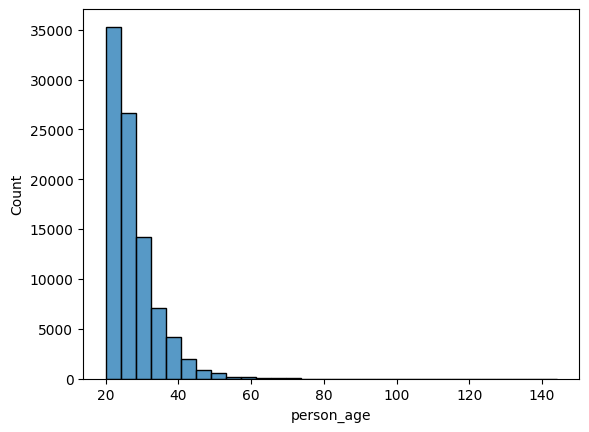

In [19]:
sns.histplot(eda['person_age'], kde=False, bins=30)
plt.show()

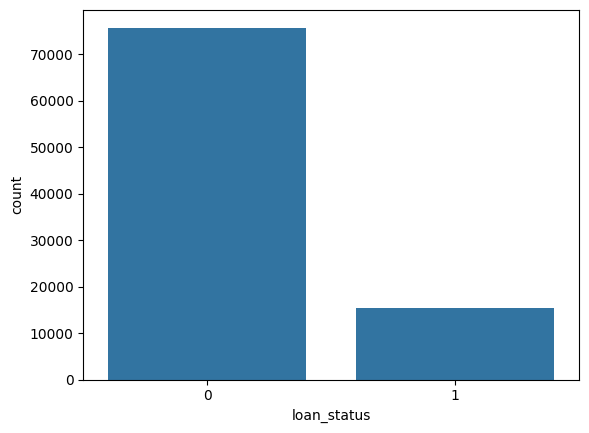

In [20]:
sns.countplot(x='loan_status', data=eda)
plt.show()

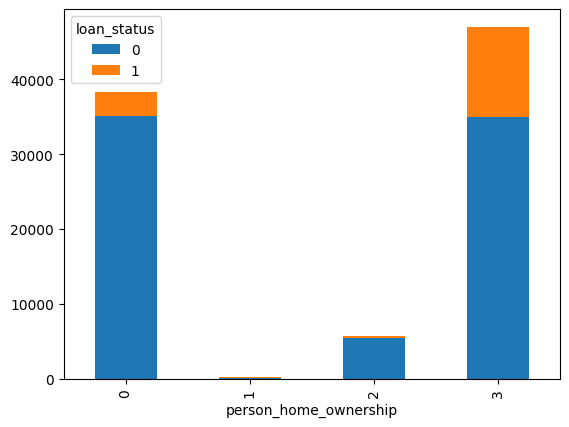

In [21]:
pd.crosstab(eda['person_home_ownership'], eda['loan_status']).plot(kind='bar', stacked=True)
plt.show()

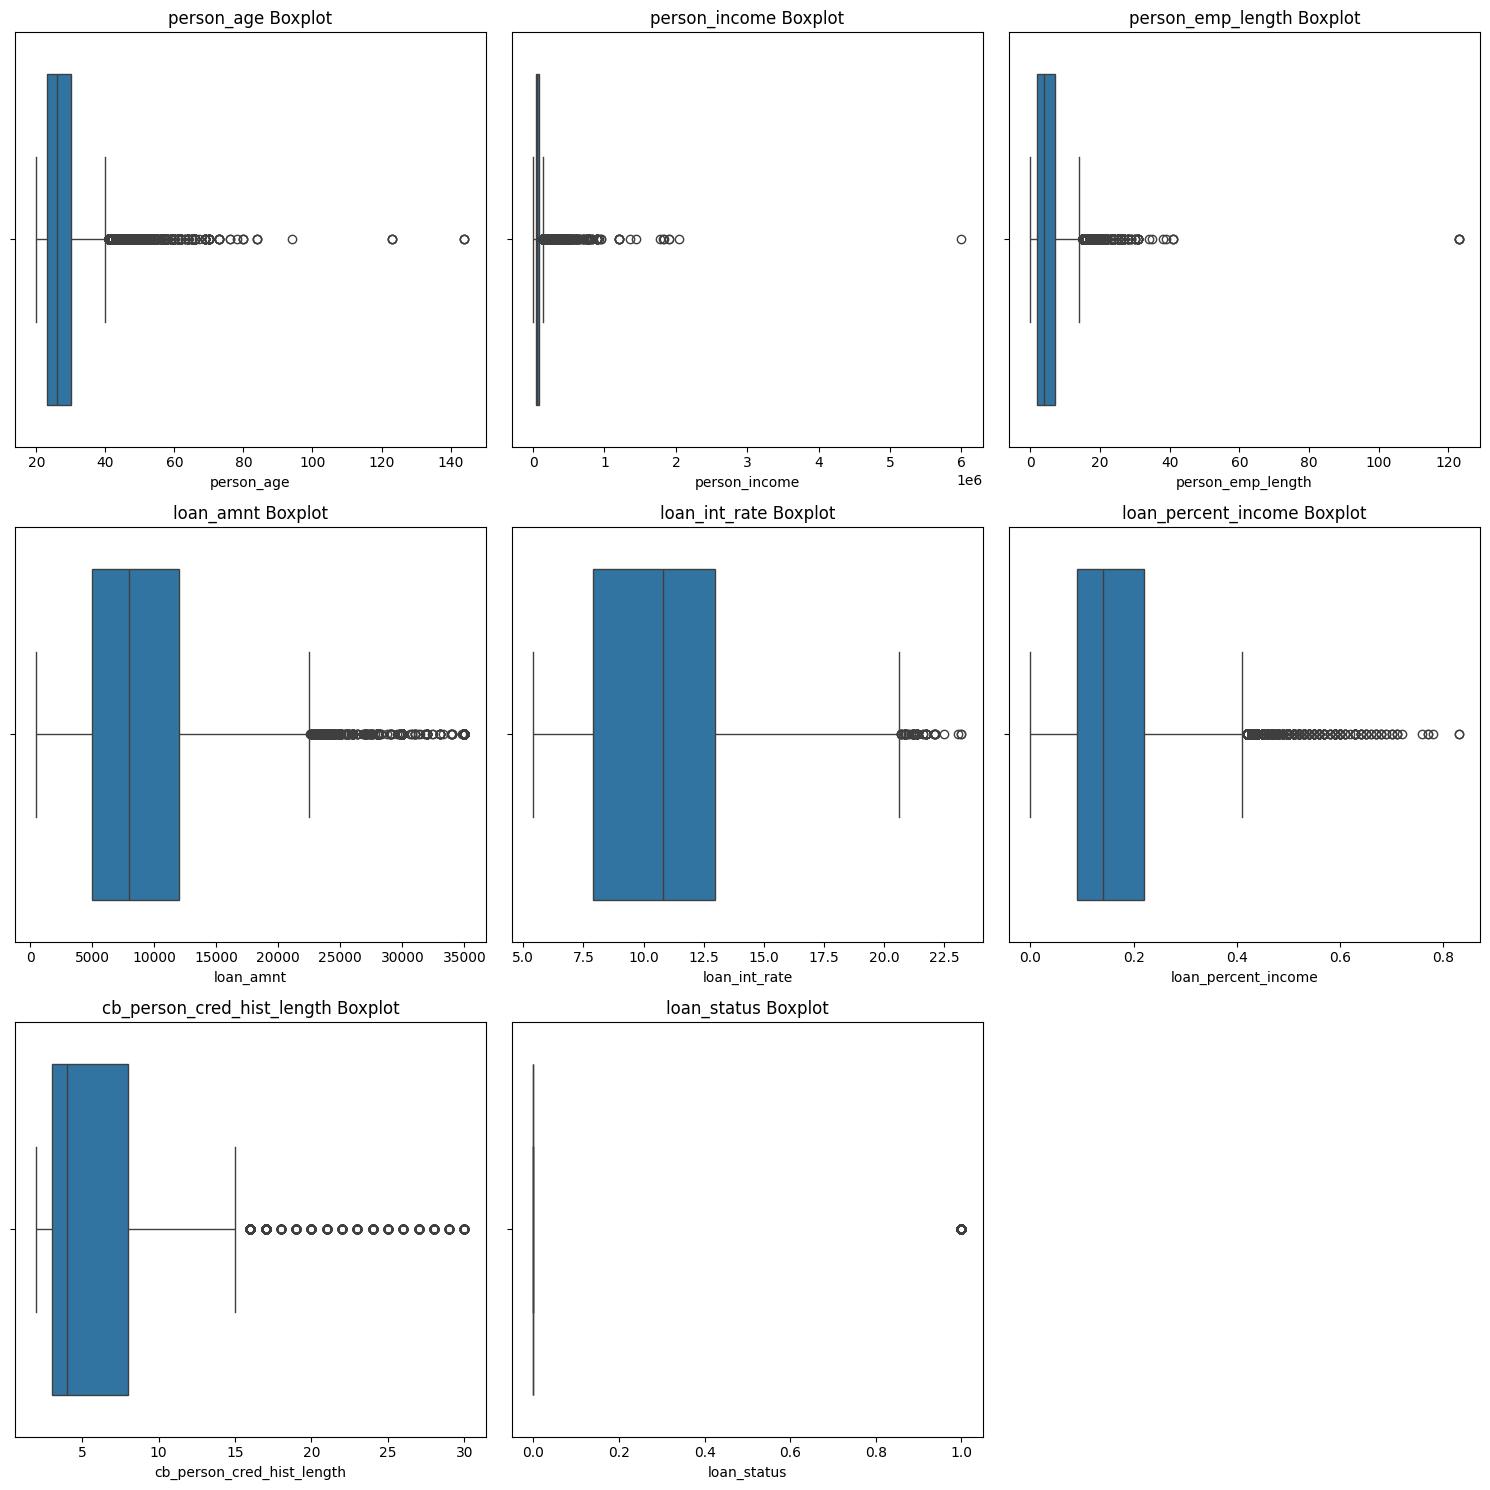

In [22]:
stats_df = pd.DataFrame(index=eda.select_dtypes(include=['float64', 'int64']).columns, columns=['Q1', 'Q3', 'IQR'])

num_features = len(eda.select_dtypes(include=['float64', 'int64']).columns)
num_cols = 3 
num_rows = math.ceil(num_features / num_cols) 

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
axs = axs.flatten()

for i, column in enumerate(eda.select_dtypes(include=['float64', 'int64']).columns):
    Q1 = eda[column].quantile(0.25)
    Q3 = eda[column].quantile(0.75)
    IQR = Q3 - Q1
    stats_df.loc[column, 'Q1'] = Q1
    stats_df.loc[column, 'Q3'] = Q3
    stats_df.loc[column, 'IQR'] = IQR

    sns.boxplot(x=eda[column], ax=axs[i])
    axs[i].set_title(f"{column} Boxplot")

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [23]:
class DataCleaner:
    def __init__(self):
        self.ti = {}
        self.ki = KNNImputer()

    def fit_label_encoders(self, df):
        cat_features = df.select_dtypes(include=["object"]).columns
        for feature in cat_features:
            le = LabelEncoder()
            le.fit(df[feature])
            self.ti[feature] = le

    def transform_labels(self, df):
        for feature, le in self.ti.items():
            df[feature] = df[feature].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        return df

    def impute_numeric(self, df):
        missed_numeric_features = df.select_dtypes(include=[float, int]).columns[df.isna().mean() > 0]
        if not missed_numeric_features.empty:
            df[missed_numeric_features] = self.ki.fit_transform(df[missed_numeric_features])
        else:
            print("No numeric columns with missing values to impute.")
        return df

    def clean_data(self, df, train):
        if train:
            self.fit_label_encoders(df)
        df = self.transform_labels(df)
        return self.impute_numeric(df)

In [24]:
data_cleaner = DataCleaner()
df = data_cleaner.clean_data(df, train=True)
test = data_cleaner.clean_data(test, train=False)

No numeric columns with missing values to impute.


In [25]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = eda[column].quantile(0.25)
    Q3 = eda[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3.5 * IQR
    upper_bound = Q3 + 3.5 * IQR

    if column != target and column != 'cb_person_default_on_file':
        num_outliers_before = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        print(f"Number of outliers in {column} before clipping: {num_outliers_before}")
    
        df = df.loc[lambda x: (x[column] >= lower_bound) & (x[column] <= upper_bound)]

        num_outliers_after = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        print(f"Number of outliers in {column} after clipping: {num_outliers_after}")

Number of outliers in person_age before clipping: 395
Number of outliers in person_age after clipping: 0
Number of outliers in person_income before clipping: 604
Number of outliers in person_income after clipping: 0
Number of outliers in person_emp_length before clipping: 67
Number of outliers in person_emp_length after clipping: 0
Number of outliers in loan_amnt before clipping: 0
Number of outliers in loan_amnt after clipping: 0
Number of outliers in loan_int_rate before clipping: 0
Number of outliers in loan_int_rate after clipping: 0
Number of outliers in loan_percent_income before clipping: 18
Number of outliers in loan_percent_income after clipping: 0
Number of outliers in cb_person_cred_hist_length before clipping: 127
Number of outliers in cb_person_cred_hist_length after clipping: 0


# Feature Engineering

In [26]:
def create_features(train, test):
    for df in [train, test]:
        df['income_to_age'] = df['person_income'] / df['person_age']
        df['loan_to_income'] = df['loan_amnt'] / df['person_income']
        df['rate_to_loan'] = df['loan_int_rate'] / df['loan_amnt']
        df['age_squared'] = df['person_age'] ** 2
        df['log_income'] = np.log1p(df['person_income'])
        df['age_credit_history_interaction'] = df['person_age'] * df['cb_person_cred_hist_length']
        df['high_loan_to_income'] = (df['loan_percent_income'] > 0.5).astype(int)
        df['loan_to_employment'] = df['loan_amnt'] / (df['person_emp_length'] + 1)
        df['is_new_credit_user'] = (df['cb_person_cred_hist_length'] < 2).astype(int)
        df['rate_to_grade'] = df.groupby('loan_grade')['loan_int_rate'].transform('mean')
        df['high_interest_rate'] = (df['loan_int_rate'] > df['loan_int_rate'].mean()).astype(int)
        df['age_to_credit_history'] = df['person_age'] / (df['cb_person_cred_hist_length'] + 1)
        df['income_home_mismatch'] = ((df['person_income'] > df['person_income'].quantile(0.8)) & (df['person_home_ownership'] == 'RENT')).astype(int)
        df['normalized_loan_amount'] = df.groupby('loan_intent')['loan_amnt'].transform(lambda x: (x - x.mean()) / x.std())
        df['income_to_loan'] = df['person_income'] / df['loan_amnt']
        df['age_cubed'] = df['person_age'] ** 3
        df['log_loan_amnt'] = np.log1p(df['loan_amnt'])
        df['age_interest_interaction'] = df['person_age'] * df['loan_int_rate']
        df['credit_history_to_age'] = df['cb_person_cred_hist_length'] / df['person_age']
        df['high_loan_amount'] = (df['loan_amnt'] > df['loan_amnt'].quantile(0.75)).astype(int)
        df['rate_to_credit_history'] = df['loan_int_rate'] / (df['cb_person_cred_hist_length'] + 1)
        df['intent_home_match'] = ((df['loan_intent'] == 'HOMEIMPROVEMENT') & (df['person_home_ownership'] == 'OWN')).astype(int)
        df['creditworthiness_score'] = (df['person_income'] / (df['loan_amnt'] * df['loan_int_rate'])) * (df['cb_person_cred_hist_length'] + 1)
        df['age_to_employment'] = df['person_age'] / (df['person_emp_length'] + 1)
        df['age_income_mismatch'] = ((df['person_age'] < 30) & (df['person_income'] > df['person_income'].quantile(0.9))).astype(int)
        df['rate_to_age'] = df['loan_int_rate'] / df['person_age']
        df['high_risk_flag'] = ((df['loan_percent_income'] > 0.4) &
                                (df['loan_int_rate'] > df['loan_int_rate'].mean()) &
                                (df['cb_person_default_on_file'] == 'Y')).astype(int)

        df['age_sin'] = np.sin(2 * np.pi * df['person_age'] / 100)
        df['age_cos'] = np.cos(2 * np.pi * df['person_age'] / 100)
        df['stability_score'] = (df['person_emp_length'] * df['person_income']) / (df['loan_amnt'] * (df['cb_person_cred_hist_length'] + 1))

    return train, test

In [27]:
df, test = create_features(df, test)

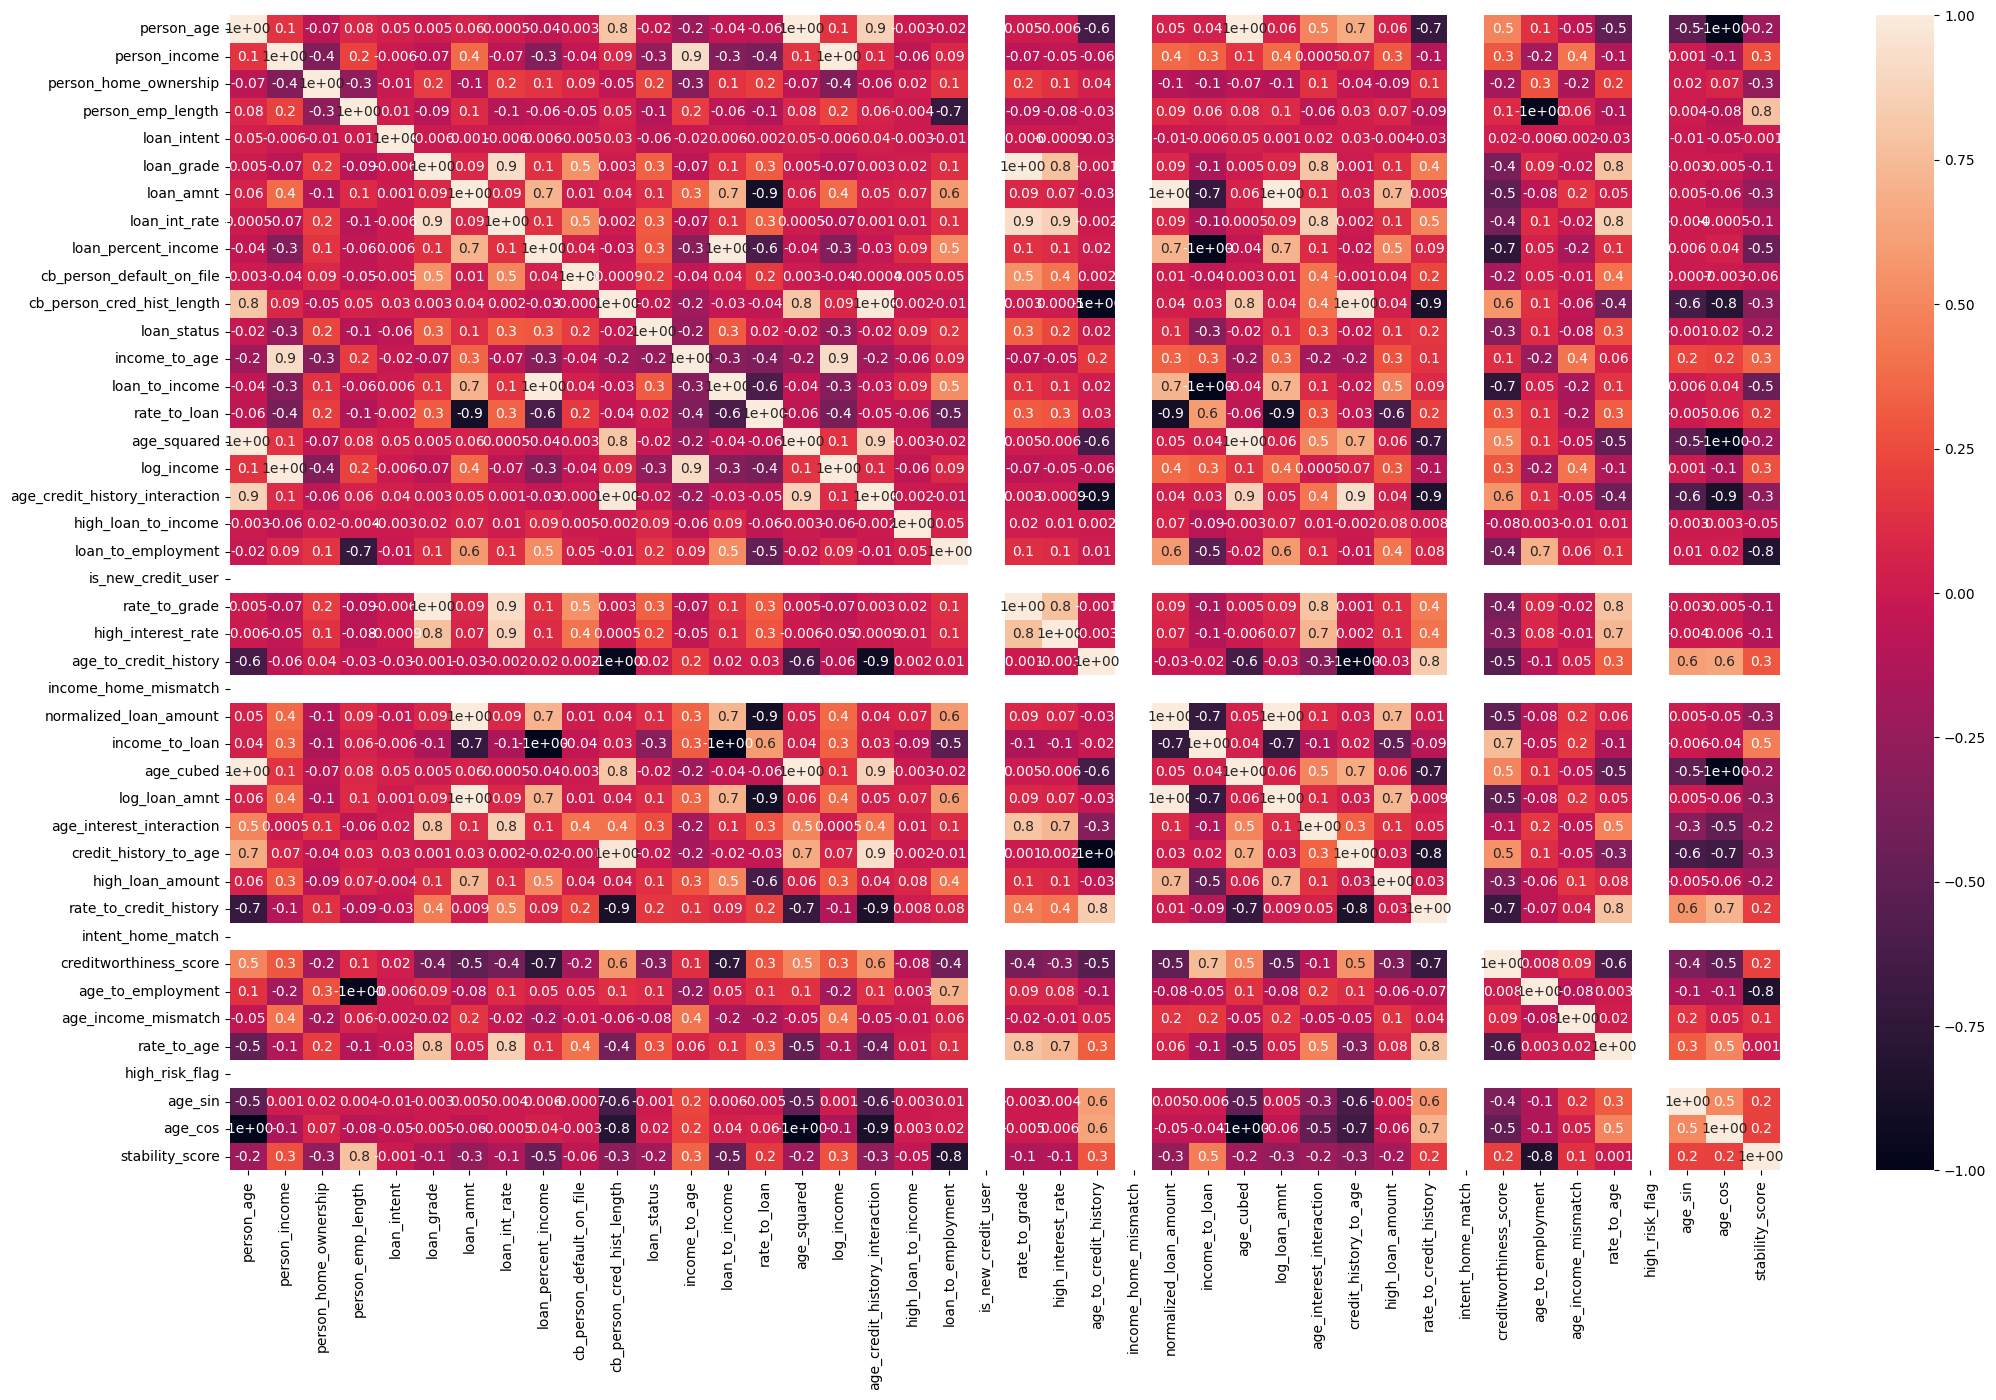

In [28]:
plt.figure(figsize=(25, 15))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".1")
plt.show()

# Modeling

In [29]:
X = df.drop(columns=target)
y = df[target]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [31]:
models = {
    "LightGBM": LGBMClassifier(device='gpu', n_jobs=-1, verbose=-1),                      
    "XGBoost": XGBClassifier(eval_metric='logloss', tree_method='gpu_hist', verbosity=0)  
}

LightGBM ROC AUC Score: 0.9542


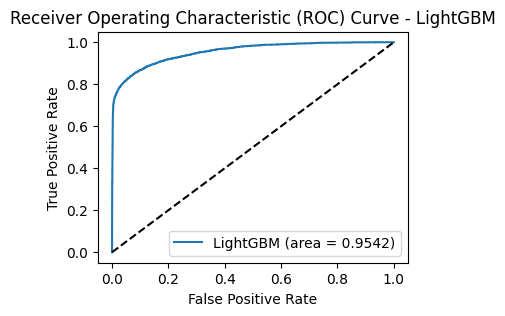

XGBoost ROC AUC Score: 0.9535


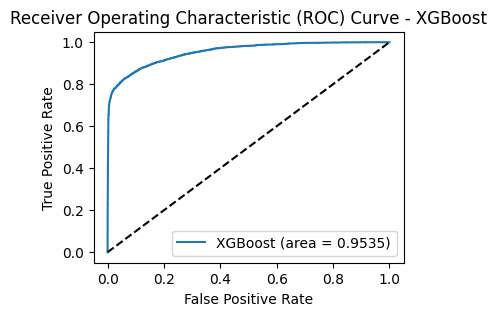

In [32]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} ROC AUC Score: {roc_auc:.4f}")
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Cross-Validation

In [33]:
for m_name, model in models.items():
    stratified_cv = StratifiedKFold(n_splits=5)
    cv_scores = cross_val_score(model, X, y, cv=stratified_cv, scoring='roc_auc')
    print(f'------------{m_name}')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", cv_scores.mean())

------------LightGBM
Cross-validation scores: [0.95686784 0.95901853 0.96217748 0.93817343 0.94105034]
Mean cross-validation score: 0.9514575239493617
------------XGBoost
Cross-validation scores: [0.95635704 0.95646921 0.95921119 0.93961094 0.93660724]
Mean cross-validation score: 0.9496511244159853


# Ensemble Methods

In [34]:
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft')
stratified_cv = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(voting_clf, X, y, cv=stratified_cv, scoring='roc_auc')
print(f'------------Voting Classifier')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

------------Voting Classifier
Cross-validation scores: [0.96006443 0.95820159 0.9579509  0.9626975  0.95689785 0.9700871
 0.92846386 0.94088421 0.94533877 0.94570087]
Mean cross-validation score: 0.9526287056042488


# Finetuning

In [35]:
class FineTune:
    def __init__(self, X, y):
        self.tuned_models = []
        self.X = X
        self.y = y

    def objective(self, trial, model, sample_size, r_s):
        X_tune = self.X.sample(sample_size, random_state=r_s)
        y_tune = self.y.sample(sample_size, random_state=r_s)

        param = {}
        if isinstance(model, XGBClassifier):
            param = {
                'objective': 'binary:logistic',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'max_depth': trial.suggest_int('max_depth', 6, 11),
                'n_estimators': trial.suggest_int('n_estimators', 800, 2000),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0)
            }
        elif isinstance(model, LGBMClassifier):
            param = {
                'max_depth': trial.suggest_int('max_depth', 6, 11),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'n_estimators': trial.suggest_int('n_estimators', 800, 2000),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0)
            }
        
        model.set_params(**param)

        cv_scores = cross_val_score(model, X_tune, y_tune, cv=5, scoring='roc_auc')
        return np.mean(cv_scores)

    def hyper_tune(self, models, n):
        for i in tqdm(range(n), desc="Tuning progress"):
            sample_size = int(len(self.X) * 0.65)
            r_s = np.random.randint(1, 51)

            for model in models:
                study = optuna.create_study(direction="maximize")
                study.optimize(lambda trial: self.objective(trial, model, sample_size, r_s), n_trials=10, show_progress_bar=True)
                tuned_model = model.set_params(**study.best_params)
                score = cross_val_score(tuned_model, self.X, self.y, cv=5, scoring='roc_auc').mean()

                self.tuned_models.append((score, tuned_model))

    def get_best_models(self, k):
        sorted_models = sorted(self.tuned_models, key=lambda x: x[0], reverse=True)
        return sorted_models[:k] if len(sorted_models) >= k else sorted_models

In [36]:
models = [
    LGBMClassifier(device='gpu', n_jobs=-1, verbose=-1),                      
    XGBClassifier(eval_metric='logloss', tree_method='gpu_hist', verbosity=0)  
]

tuner = FineTune(X, y)
tuner.hyper_tune(models, n=10)

Tuning progress:   0%|          | 0/10 [00:00<?, ?it/s][I 2024-11-23 02:08:40,543] A new study created in memory with name: no-name-92e740f0-499c-44e0-8f53-9bb4bfaa6c9a


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:   0%|          | 0/10 [01:04<?, ?it/s]

[I 2024-11-23 02:09:44,871] Trial 0 finished with value: 0.9516764851094571 and parameters: {'max_depth': 9, 'learning_rate': 0.08156420451455669, 'n_estimators': 1080, 'subsample': 0.5960510335779379}. Best is trial 0 with value: 0.9516764851094571.


Tuning progress:   0%|          | 0/10 [02:24<?, ?it/s]

[I 2024-11-23 02:11:05,112] Trial 1 finished with value: 0.9532940284158086 and parameters: {'max_depth': 7, 'learning_rate': 0.030935797367775845, 'n_estimators': 1597, 'subsample': 0.5409745673323438}. Best is trial 1 with value: 0.9532940284158086.


Tuning progress:   0%|          | 0/10 [03:19<?, ?it/s]

[I 2024-11-23 02:12:00,340] Trial 2 finished with value: 0.9515014037300732 and parameters: {'max_depth': 7, 'learning_rate': 0.07970144183318309, 'n_estimators': 1005, 'subsample': 0.5721149112708359}. Best is trial 1 with value: 0.9532940284158086.


Tuning progress:   0%|          | 0/10 [05:03<?, ?it/s]

[I 2024-11-23 02:13:44,003] Trial 3 finished with value: 0.9509710963079643 and parameters: {'max_depth': 9, 'learning_rate': 0.05366064539072922, 'n_estimators': 1973, 'subsample': 0.8153428114303439}. Best is trial 1 with value: 0.9532940284158086.


Tuning progress:   0%|          | 0/10 [06:23<?, ?it/s]

[I 2024-11-23 02:15:03,553] Trial 4 finished with value: 0.9512013735538097 and parameters: {'max_depth': 10, 'learning_rate': 0.0787559269083816, 'n_estimators': 1480, 'subsample': 0.5784630081075585}. Best is trial 1 with value: 0.9532940284158086.


Tuning progress:   0%|          | 0/10 [07:29<?, ?it/s]

[I 2024-11-23 02:16:10,267] Trial 5 finished with value: 0.9530914179733289 and parameters: {'max_depth': 7, 'learning_rate': 0.04348656740458914, 'n_estimators': 1367, 'subsample': 0.7777009158183965}. Best is trial 1 with value: 0.9532940284158086.


Tuning progress:   0%|          | 0/10 [08:26<?, ?it/s]

[I 2024-11-23 02:17:07,306] Trial 6 finished with value: 0.9527325896400981 and parameters: {'max_depth': 7, 'learning_rate': 0.05772306527468844, 'n_estimators': 1160, 'subsample': 0.93140166656889}. Best is trial 1 with value: 0.9532940284158086.


Tuning progress:   0%|          | 0/10 [09:45<?, ?it/s]

[I 2024-11-23 02:18:25,702] Trial 7 finished with value: 0.9503619284478582 and parameters: {'max_depth': 8, 'learning_rate': 0.08838543915341321, 'n_estimators': 1550, 'subsample': 0.5034609723182242}. Best is trial 1 with value: 0.9532940284158086.


Tuning progress:   0%|          | 0/10 [10:50<?, ?it/s]

[I 2024-11-23 02:19:30,878] Trial 8 finished with value: 0.9504930520667824 and parameters: {'max_depth': 10, 'learning_rate': 0.09749336665460095, 'n_estimators': 1208, 'subsample': 0.8451443156628091}. Best is trial 1 with value: 0.9532940284158086.


Tuning progress:   0%|          | 0/10 [11:58<?, ?it/s]

[I 2024-11-23 02:20:38,764] Trial 9 finished with value: 0.9544764987689248 and parameters: {'max_depth': 9, 'learning_rate': 0.025333995121709488, 'n_estimators': 1269, 'subsample': 0.9170909251454031}. Best is trial 9 with value: 0.9544764987689248.


[I 2024-11-23 02:21:48,109] A new study created in memory with name: no-name-e6948c8e-8a98-4ed7-9315-c5cfb21fbde2


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:   0%|          | 0/10 [14:24<?, ?it/s]

[I 2024-11-23 02:23:04,869] Trial 0 finished with value: 0.9413764204764424 and parameters: {'learning_rate': 0.09855336100843806, 'max_depth': 11, 'n_estimators': 1309, 'subsample': 0.6179362244269054}. Best is trial 0 with value: 0.9413764204764424.


Tuning progress:   0%|          | 0/10 [15:11<?, ?it/s]

[I 2024-11-23 02:23:51,950] Trial 1 finished with value: 0.9472599143326491 and parameters: {'learning_rate': 0.06817075662005873, 'max_depth': 7, 'n_estimators': 1399, 'subsample': 0.8021697598426699}. Best is trial 1 with value: 0.9472599143326491.


Tuning progress:   0%|          | 0/10 [15:57<?, ?it/s]

[I 2024-11-23 02:24:38,514] Trial 2 finished with value: 0.9473400787513949 and parameters: {'learning_rate': 0.08897814448218866, 'max_depth': 8, 'n_estimators': 1178, 'subsample': 0.9184264920412253}. Best is trial 2 with value: 0.9473400787513949.


Tuning progress:   0%|          | 0/10 [17:19<?, ?it/s]

[I 2024-11-23 02:26:00,033] Trial 3 finished with value: 0.9420825123954147 and parameters: {'learning_rate': 0.06692858669313308, 'max_depth': 11, 'n_estimators': 1196, 'subsample': 0.5289669697013556}. Best is trial 2 with value: 0.9473400787513949.


Tuning progress:   0%|          | 0/10 [17:59<?, ?it/s]

[I 2024-11-23 02:26:39,551] Trial 4 finished with value: 0.9484902984012079 and parameters: {'learning_rate': 0.055578964414742825, 'max_depth': 6, 'n_estimators': 1462, 'subsample': 0.7369726890384729}. Best is trial 4 with value: 0.9484902984012079.


Tuning progress:   0%|          | 0/10 [18:38<?, ?it/s]

[I 2024-11-23 02:27:19,311] Trial 5 finished with value: 0.9443708275801255 and parameters: {'learning_rate': 0.08902353058667611, 'max_depth': 6, 'n_estimators': 1367, 'subsample': 0.5679261342659558}. Best is trial 4 with value: 0.9484902984012079.


Tuning progress:   0%|          | 0/10 [20:07<?, ?it/s]

[I 2024-11-23 02:28:48,468] Trial 6 finished with value: 0.947198989588319 and parameters: {'learning_rate': 0.023698414052702486, 'max_depth': 10, 'n_estimators': 1333, 'subsample': 0.6704141595307623}. Best is trial 4 with value: 0.9484902984012079.


Tuning progress:   0%|          | 0/10 [20:57<?, ?it/s]

[I 2024-11-23 02:29:37,674] Trial 7 finished with value: 0.9471309367136508 and parameters: {'learning_rate': 0.06238310259125476, 'max_depth': 8, 'n_estimators': 1180, 'subsample': 0.7858425919650395}. Best is trial 4 with value: 0.9484902984012079.


Tuning progress:   0%|          | 0/10 [22:14<?, ?it/s]

[I 2024-11-23 02:30:55,278] Trial 8 finished with value: 0.9455962142827034 and parameters: {'learning_rate': 0.04523436776604663, 'max_depth': 11, 'n_estimators': 1179, 'subsample': 0.7126263211066115}. Best is trial 4 with value: 0.9484902984012079.


Tuning progress:   0%|          | 0/10 [22:50<?, ?it/s]

[I 2024-11-23 02:31:31,386] Trial 9 finished with value: 0.9469959458159714 and parameters: {'learning_rate': 0.08469750758773555, 'max_depth': 6, 'n_estimators': 1634, 'subsample': 0.8058087730328476}. Best is trial 4 with value: 0.9484902984012079.


Tuning progress:  10%|█         | 1/10 [23:26<3:30:58, 1406.48s/it][I 2024-11-23 02:32:07,032] A new study created in memory with name: no-name-63a9b929-3b9c-48fa-82cd-c58277f979a5


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  10%|█         | 1/10 [24:20<3:30:58, 1406.48s/it]

[I 2024-11-23 02:33:00,590] Trial 0 finished with value: 0.951063487018897 and parameters: {'max_depth': 6, 'learning_rate': 0.07843833006241037, 'n_estimators': 1522, 'subsample': 0.5586780592940557}. Best is trial 0 with value: 0.951063487018897.


Tuning progress:  10%|█         | 1/10 [24:49<3:30:58, 1406.48s/it]

[I 2024-11-23 02:33:30,295] Trial 1 finished with value: 0.9533692921539286 and parameters: {'max_depth': 6, 'learning_rate': 0.07690299741498535, 'n_estimators': 830, 'subsample': 0.524915993218463}. Best is trial 1 with value: 0.9533692921539286.


Tuning progress:  10%|█         | 1/10 [25:36<3:30:58, 1406.48s/it]

[I 2024-11-23 02:34:17,491] Trial 2 finished with value: 0.9519410441552466 and parameters: {'max_depth': 6, 'learning_rate': 0.06959728654148906, 'n_estimators': 1408, 'subsample': 0.7481790629047462}. Best is trial 1 with value: 0.9533692921539286.


Tuning progress:  10%|█         | 1/10 [26:19<3:30:58, 1406.48s/it]

[I 2024-11-23 02:35:00,202] Trial 3 finished with value: 0.9537169329494194 and parameters: {'max_depth': 10, 'learning_rate': 0.055914467634845255, 'n_estimators': 1043, 'subsample': 0.9584488271003002}. Best is trial 3 with value: 0.9537169329494194.


Tuning progress:  10%|█         | 1/10 [27:47<3:30:58, 1406.48s/it]

[I 2024-11-23 02:36:28,376] Trial 4 finished with value: 0.9512525708369441 and parameters: {'max_depth': 11, 'learning_rate': 0.060371605260350514, 'n_estimators': 1919, 'subsample': 0.9724162611726102}. Best is trial 3 with value: 0.9537169329494194.


Tuning progress:  10%|█         | 1/10 [30:28<3:30:58, 1406.48s/it]

[I 2024-11-23 02:39:08,588] Trial 5 finished with value: 0.9495433599526306 and parameters: {'max_depth': 7, 'learning_rate': 0.08656053352757752, 'n_estimators': 1977, 'subsample': 0.7507863363112002}. Best is trial 3 with value: 0.9537169329494194.


Tuning progress:  10%|█         | 1/10 [32:25<3:30:58, 1406.48s/it]

[I 2024-11-23 02:41:05,586] Trial 6 finished with value: 0.9540388058176251 and parameters: {'max_depth': 7, 'learning_rate': 0.011528625944358495, 'n_estimators': 1369, 'subsample': 0.9066573990282542}. Best is trial 6 with value: 0.9540388058176251.


Tuning progress:  10%|█         | 1/10 [33:57<3:30:58, 1406.48s/it]

[I 2024-11-23 02:42:37,842] Trial 7 finished with value: 0.952557041546451 and parameters: {'max_depth': 9, 'learning_rate': 0.0806506759712248, 'n_estimators': 1093, 'subsample': 0.617016922553989}. Best is trial 6 with value: 0.9540388058176251.


Tuning progress:  10%|█         | 1/10 [35:43<3:30:58, 1406.48s/it]

[I 2024-11-23 02:44:24,011] Trial 8 finished with value: 0.9520359902811597 and parameters: {'max_depth': 8, 'learning_rate': 0.07190519552183944, 'n_estimators': 1269, 'subsample': 0.5812828864499974}. Best is trial 6 with value: 0.9540388058176251.


Tuning progress:  10%|█         | 1/10 [37:21<3:30:58, 1406.48s/it]

[I 2024-11-23 02:46:02,320] Trial 9 finished with value: 0.9533409302303364 and parameters: {'max_depth': 10, 'learning_rate': 0.05880672921037511, 'n_estimators': 1093, 'subsample': 0.5019748166883307}. Best is trial 6 with value: 0.9540388058176251.


[I 2024-11-23 02:48:17,513] A new study created in memory with name: no-name-d91e1b59-dcaa-4dce-b518-13e704e3bab1


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  10%|█         | 1/10 [40:15<3:30:58, 1406.48s/it]

[I 2024-11-23 02:48:55,980] Trial 0 finished with value: 0.9531060419400914 and parameters: {'learning_rate': 0.034484774020517084, 'max_depth': 6, 'n_estimators': 1191, 'subsample': 0.9857455706434994}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  10%|█         | 1/10 [40:41<3:30:58, 1406.48s/it]

[I 2024-11-23 02:49:22,299] Trial 1 finished with value: 0.9530339539490402 and parameters: {'learning_rate': 0.02989909117783869, 'max_depth': 6, 'n_estimators': 875, 'subsample': 0.8355025407620973}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  10%|█         | 1/10 [41:21<3:30:58, 1406.48s/it]

[I 2024-11-23 02:50:01,796] Trial 2 finished with value: 0.950187924373721 and parameters: {'learning_rate': 0.05957928299326508, 'max_depth': 8, 'n_estimators': 860, 'subsample': 0.9698975007957656}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  10%|█         | 1/10 [42:08<3:30:58, 1406.48s/it]

[I 2024-11-23 02:50:49,366] Trial 3 finished with value: 0.9492814481220353 and parameters: {'learning_rate': 0.04601329640717776, 'max_depth': 8, 'n_estimators': 932, 'subsample': 0.7914512630094471}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  10%|█         | 1/10 [43:29<3:30:58, 1406.48s/it]

[I 2024-11-23 02:52:09,909] Trial 4 finished with value: 0.9453615317738142 and parameters: {'learning_rate': 0.08567193910294156, 'max_depth': 9, 'n_estimators': 1455, 'subsample': 0.7577570230972803}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  10%|█         | 1/10 [44:40<3:30:58, 1406.48s/it]

[I 2024-11-23 02:53:21,402] Trial 5 finished with value: 0.9454529662329973 and parameters: {'learning_rate': 0.05691604367390504, 'max_depth': 8, 'n_estimators': 1509, 'subsample': 0.597981750644877}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  10%|█         | 1/10 [46:26<3:30:58, 1406.48s/it]

[I 2024-11-23 02:55:07,235] Trial 6 finished with value: 0.9424320295879589 and parameters: {'learning_rate': 0.06288933700302712, 'max_depth': 11, 'n_estimators': 1517, 'subsample': 0.5161496796782048}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  10%|█         | 1/10 [47:54<3:30:58, 1406.48s/it]

[I 2024-11-23 02:56:34,836] Trial 7 finished with value: 0.9458967832153883 and parameters: {'learning_rate': 0.04664425631813176, 'max_depth': 7, 'n_estimators': 1658, 'subsample': 0.5778167644175465}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  10%|█         | 1/10 [48:27<3:30:58, 1406.48s/it]

[I 2024-11-23 02:57:07,914] Trial 8 finished with value: 0.9499398379117261 and parameters: {'learning_rate': 0.054879665385606305, 'max_depth': 7, 'n_estimators': 838, 'subsample': 0.7401961472229609}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  10%|█         | 1/10 [51:00<3:30:58, 1406.48s/it]

[I 2024-11-23 02:59:41,199] Trial 9 finished with value: 0.9494386385675927 and parameters: {'learning_rate': 0.015578315186142857, 'max_depth': 10, 'n_estimators': 1978, 'subsample': 0.8001285423626683}. Best is trial 0 with value: 0.9531060419400914.


Tuning progress:  20%|██        | 2/10 [51:38<3:29:53, 1574.16s/it][I 2024-11-23 03:00:18,560] A new study created in memory with name: no-name-725870c0-33b8-4df1-b4d5-d08fdbd41e10


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  20%|██        | 2/10 [53:38<3:29:53, 1574.16s/it]

[I 2024-11-23 03:02:18,549] Trial 0 finished with value: 0.9536224545756816 and parameters: {'max_depth': 6, 'learning_rate': 0.02402643463951849, 'n_estimators': 1559, 'subsample': 0.6007191329778456}. Best is trial 0 with value: 0.9536224545756816.


Tuning progress:  20%|██        | 2/10 [55:58<3:29:53, 1574.16s/it]

[I 2024-11-23 03:04:39,383] Trial 1 finished with value: 0.94866098573372 and parameters: {'max_depth': 10, 'learning_rate': 0.08985036185358679, 'n_estimators': 1582, 'subsample': 0.8786684660237776}. Best is trial 0 with value: 0.9536224545756816.


Tuning progress:  20%|██        | 2/10 [57:20<3:29:53, 1574.16s/it]

[I 2024-11-23 03:06:00,839] Trial 2 finished with value: 0.9536676827991011 and parameters: {'max_depth': 7, 'learning_rate': 0.03864230019549894, 'n_estimators': 978, 'subsample': 0.7987166785808519}. Best is trial 2 with value: 0.9536676827991011.


Tuning progress:  20%|██        | 2/10 [59:38<3:29:53, 1574.16s/it]

[I 2024-11-23 03:08:18,749] Trial 3 finished with value: 0.9480174479151044 and parameters: {'max_depth': 7, 'learning_rate': 0.09441112371972876, 'n_estimators': 1701, 'subsample': 0.7542080649265508}. Best is trial 2 with value: 0.9536676827991011.


Tuning progress:  20%|██        | 2/10 [1:01:22<3:29:53, 1574.16s/it]

[I 2024-11-23 03:10:03,064] Trial 4 finished with value: 0.9497505208922508 and parameters: {'max_depth': 11, 'learning_rate': 0.07897107971919469, 'n_estimators': 1503, 'subsample': 0.7442913760907931}. Best is trial 2 with value: 0.9536676827991011.


Tuning progress:  20%|██        | 2/10 [1:02:24<3:29:53, 1574.16s/it]

[I 2024-11-23 03:11:04,713] Trial 5 finished with value: 0.953815325861884 and parameters: {'max_depth': 6, 'learning_rate': 0.01824679058296237, 'n_estimators': 1951, 'subsample': 0.8898929345429004}. Best is trial 5 with value: 0.953815325861884.


Tuning progress:  20%|██        | 2/10 [1:03:31<3:29:53, 1574.16s/it]

[I 2024-11-23 03:12:12,198] Trial 6 finished with value: 0.9496731171910973 and parameters: {'max_depth': 9, 'learning_rate': 0.06921042782419078, 'n_estimators': 1925, 'subsample': 0.6423567712999262}. Best is trial 5 with value: 0.953815325861884.


Tuning progress:  20%|██        | 2/10 [1:04:15<3:29:53, 1574.16s/it]

[I 2024-11-23 03:12:55,554] Trial 7 finished with value: 0.9504420173825994 and parameters: {'max_depth': 10, 'learning_rate': 0.07855014730532778, 'n_estimators': 1312, 'subsample': 0.7705037451481402}. Best is trial 5 with value: 0.953815325861884.


Tuning progress:  20%|██        | 2/10 [1:04:47<3:29:53, 1574.16s/it]

[I 2024-11-23 03:13:28,454] Trial 8 finished with value: 0.9532833555838875 and parameters: {'max_depth': 7, 'learning_rate': 0.03755860429914842, 'n_estimators': 1112, 'subsample': 0.5763521189780034}. Best is trial 5 with value: 0.953815325861884.


Tuning progress:  20%|██        | 2/10 [1:05:10<3:29:53, 1574.16s/it]

[I 2024-11-23 03:13:51,467] Trial 9 finished with value: 0.9536081673864103 and parameters: {'max_depth': 6, 'learning_rate': 0.03891829417718679, 'n_estimators': 823, 'subsample': 0.7224180182145556}. Best is trial 5 with value: 0.953815325861884.


[I 2024-11-23 03:15:11,568] A new study created in memory with name: no-name-f2b0f551-043f-4c04-8186-28cc4de2521e


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  20%|██        | 2/10 [1:07:10<3:29:53, 1574.16s/it]

[I 2024-11-23 03:15:51,327] Trial 0 finished with value: 0.9499773968780335 and parameters: {'learning_rate': 0.04302517060347302, 'max_depth': 6, 'n_estimators': 1885, 'subsample': 0.8948212129641051}. Best is trial 0 with value: 0.9499773968780335.


Tuning progress:  20%|██        | 2/10 [1:07:51<3:29:53, 1574.16s/it]

[I 2024-11-23 03:16:32,350] Trial 1 finished with value: 0.947484824778089 and parameters: {'learning_rate': 0.049884216029585114, 'max_depth': 9, 'n_estimators': 1057, 'subsample': 0.9880374738117175}. Best is trial 0 with value: 0.9499773968780335.


Tuning progress:  20%|██        | 2/10 [1:08:37<3:29:53, 1574.16s/it]

[I 2024-11-23 03:17:17,665] Trial 2 finished with value: 0.9471618592824471 and parameters: {'learning_rate': 0.022018713504835023, 'max_depth': 9, 'n_estimators': 969, 'subsample': 0.5571529458695834}. Best is trial 0 with value: 0.9499773968780335.


Tuning progress:  20%|██        | 2/10 [1:09:16<3:29:53, 1574.16s/it]

[I 2024-11-23 03:17:57,312] Trial 3 finished with value: 0.9512686976201076 and parameters: {'learning_rate': 0.018398888871145658, 'max_depth': 6, 'n_estimators': 1881, 'subsample': 0.7433829865392232}. Best is trial 3 with value: 0.9512686976201076.


Tuning progress:  20%|██        | 2/10 [1:09:47<3:29:53, 1574.16s/it]

[I 2024-11-23 03:18:27,873] Trial 4 finished with value: 0.9491842861464855 and parameters: {'learning_rate': 0.04676937842035586, 'max_depth': 7, 'n_estimators': 1132, 'subsample': 0.8504116926648075}. Best is trial 3 with value: 0.9512686976201076.


Tuning progress:  20%|██        | 2/10 [1:10:38<3:29:53, 1574.16s/it]

[I 2024-11-23 03:19:19,416] Trial 5 finished with value: 0.9464652343447177 and parameters: {'learning_rate': 0.07372703182645188, 'max_depth': 8, 'n_estimators': 1658, 'subsample': 0.8584131487237938}. Best is trial 3 with value: 0.9512686976201076.


Tuning progress:  20%|██        | 2/10 [1:11:20<3:29:53, 1574.16s/it]

[I 2024-11-23 03:20:01,219] Trial 6 finished with value: 0.9409220855213096 and parameters: {'learning_rate': 0.0985535697564443, 'max_depth': 9, 'n_estimators': 1058, 'subsample': 0.5469840862952982}. Best is trial 3 with value: 0.9512686976201076.


Tuning progress:  20%|██        | 2/10 [1:12:07<3:29:53, 1574.16s/it]

[I 2024-11-23 03:20:48,346] Trial 7 finished with value: 0.9433254669373493 and parameters: {'learning_rate': 0.09603372635587204, 'max_depth': 11, 'n_estimators': 929, 'subsample': 0.7554091899576842}. Best is trial 3 with value: 0.9512686976201076.


Tuning progress:  20%|██        | 2/10 [1:13:10<3:29:53, 1574.16s/it]

[I 2024-11-23 03:21:50,802] Trial 8 finished with value: 0.9423280121677371 and parameters: {'learning_rate': 0.06483362040465808, 'max_depth': 9, 'n_estimators': 1531, 'subsample': 0.5337008850902194}. Best is trial 3 with value: 0.9512686976201076.


Tuning progress:  20%|██        | 2/10 [1:14:31<3:29:53, 1574.16s/it]

[I 2024-11-23 03:23:12,496] Trial 9 finished with value: 0.9460215427760836 and parameters: {'learning_rate': 0.06701893588169973, 'max_depth': 9, 'n_estimators': 1891, 'subsample': 0.9122329856283661}. Best is trial 3 with value: 0.9512686976201076.


Tuning progress:  30%|███       | 3/10 [1:15:14<2:55:13, 1501.97s/it][I 2024-11-23 03:23:54,615] A new study created in memory with name: no-name-fe0adf9f-c6f9-4b06-9bee-41d8a42f8abb


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  30%|███       | 3/10 [1:17:00<2:55:13, 1501.97s/it]

[I 2024-11-23 03:25:40,665] Trial 0 finished with value: 0.9508401911570481 and parameters: {'max_depth': 7, 'learning_rate': 0.05794795719021393, 'n_estimators': 1911, 'subsample': 0.6857444402141255}. Best is trial 0 with value: 0.9508401911570481.


Tuning progress:  30%|███       | 3/10 [1:18:30<2:55:13, 1501.97s/it]

[I 2024-11-23 03:27:10,588] Trial 1 finished with value: 0.9488602698025472 and parameters: {'max_depth': 6, 'learning_rate': 0.08969374258158246, 'n_estimators': 1783, 'subsample': 0.6068084708620901}. Best is trial 0 with value: 0.9508401911570481.


Tuning progress:  30%|███       | 3/10 [1:19:51<2:55:13, 1501.97s/it]

[I 2024-11-23 03:28:31,604] Trial 2 finished with value: 0.9519986345947654 and parameters: {'max_depth': 9, 'learning_rate': 0.05733032127722071, 'n_estimators': 1417, 'subsample': 0.5049446875845003}. Best is trial 2 with value: 0.9519986345947654.


Tuning progress:  30%|███       | 3/10 [1:21:11<2:55:13, 1501.97s/it]

[I 2024-11-23 03:29:52,072] Trial 3 finished with value: 0.9517761791770318 and parameters: {'max_depth': 11, 'learning_rate': 0.07346594331185995, 'n_estimators': 1382, 'subsample': 0.7972081804138458}. Best is trial 2 with value: 0.9519986345947654.


Tuning progress:  30%|███       | 3/10 [1:22:05<2:55:13, 1501.97s/it]

[I 2024-11-23 03:30:45,735] Trial 4 finished with value: 0.9507877163891342 and parameters: {'max_depth': 8, 'learning_rate': 0.09999274405732664, 'n_estimators': 1047, 'subsample': 0.5630264575992499}. Best is trial 2 with value: 0.9519986345947654.


Tuning progress:  30%|███       | 3/10 [1:22:53<2:55:13, 1501.97s/it]

[I 2024-11-23 03:31:34,228] Trial 5 finished with value: 0.9524465897039581 and parameters: {'max_depth': 9, 'learning_rate': 0.07928885055650811, 'n_estimators': 939, 'subsample': 0.7451961062072626}. Best is trial 5 with value: 0.9524465897039581.


Tuning progress:  30%|███       | 3/10 [1:24:00<2:55:13, 1501.97s/it]

[I 2024-11-23 03:32:40,729] Trial 6 finished with value: 0.9516660054023205 and parameters: {'max_depth': 9, 'learning_rate': 0.08047533827749936, 'n_estimators': 1213, 'subsample': 0.8017222332766234}. Best is trial 5 with value: 0.9524465897039581.


Tuning progress:  30%|███       | 3/10 [1:24:38<2:55:13, 1501.97s/it]

[I 2024-11-23 03:33:19,050] Trial 7 finished with value: 0.9539964343488482 and parameters: {'max_depth': 6, 'learning_rate': 0.04005575339459964, 'n_estimators': 854, 'subsample': 0.992962978397776}. Best is trial 7 with value: 0.9539964343488482.


Tuning progress:  30%|███       | 3/10 [1:26:42<2:55:13, 1501.97s/it]

[I 2024-11-23 03:35:23,294] Trial 8 finished with value: 0.953756467562999 and parameters: {'max_depth': 11, 'learning_rate': 0.026088833343442953, 'n_estimators': 1983, 'subsample': 0.7278042533855438}. Best is trial 7 with value: 0.9539964343488482.


Tuning progress:  30%|███       | 3/10 [1:27:46<2:55:13, 1501.97s/it]

[I 2024-11-23 03:36:26,650] Trial 9 finished with value: 0.95315394131212 and parameters: {'max_depth': 10, 'learning_rate': 0.05109275649775717, 'n_estimators': 1134, 'subsample': 0.6779165840400778}. Best is trial 7 with value: 0.9539964343488482.


[I 2024-11-23 03:37:08,280] A new study created in memory with name: no-name-ad31917a-e90b-4df0-82c0-05edc16c521c


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  30%|███       | 3/10 [1:28:50<2:55:13, 1501.97s/it]

[I 2024-11-23 03:37:31,487] Trial 0 finished with value: 0.9455633702538343 and parameters: {'learning_rate': 0.07216758391495626, 'max_depth': 7, 'n_estimators': 800, 'subsample': 0.581763113817941}. Best is trial 0 with value: 0.9455633702538343.


Tuning progress:  30%|███       | 3/10 [1:29:33<2:55:13, 1501.97s/it]

[I 2024-11-23 03:38:13,762] Trial 1 finished with value: 0.950109970089145 and parameters: {'learning_rate': 0.038045579190614506, 'max_depth': 7, 'n_estimators': 1571, 'subsample': 0.9788536022848584}. Best is trial 1 with value: 0.950109970089145.


Tuning progress:  30%|███       | 3/10 [1:30:19<2:55:13, 1501.97s/it]

[I 2024-11-23 03:38:59,927] Trial 2 finished with value: 0.9495324357604599 and parameters: {'learning_rate': 0.031771984693674725, 'max_depth': 9, 'n_estimators': 1072, 'subsample': 0.8383776316402582}. Best is trial 1 with value: 0.950109970089145.


Tuning progress:  30%|███       | 3/10 [1:31:15<2:55:13, 1501.97s/it]

[I 2024-11-23 03:39:56,090] Trial 3 finished with value: 0.9452300162951639 and parameters: {'learning_rate': 0.035490530662926366, 'max_depth': 8, 'n_estimators': 1590, 'subsample': 0.5433364906846395}. Best is trial 1 with value: 0.950109970089145.


Tuning progress:  30%|███       | 3/10 [1:31:47<2:55:13, 1501.97s/it]

[I 2024-11-23 03:40:27,652] Trial 4 finished with value: 0.9470228700029422 and parameters: {'learning_rate': 0.0744832707039855, 'max_depth': 8, 'n_estimators': 902, 'subsample': 0.7507506469013479}. Best is trial 1 with value: 0.950109970089145.


Tuning progress:  30%|███       | 3/10 [1:33:04<2:55:13, 1501.97s/it]

[I 2024-11-23 03:41:44,713] Trial 5 finished with value: 0.944587897422662 and parameters: {'learning_rate': 0.043940649856897725, 'max_depth': 9, 'n_estimators': 1893, 'subsample': 0.6326141902328946}. Best is trial 1 with value: 0.950109970089145.


Tuning progress:  30%|███       | 3/10 [1:33:42<2:55:13, 1501.97s/it]

[I 2024-11-23 03:42:23,440] Trial 6 finished with value: 0.9517781646415641 and parameters: {'learning_rate': 0.011269034656178008, 'max_depth': 8, 'n_estimators': 1093, 'subsample': 0.7903624941147014}. Best is trial 6 with value: 0.9517781646415641.


Tuning progress:  30%|███       | 3/10 [1:34:46<2:55:13, 1501.97s/it]

[I 2024-11-23 03:43:27,372] Trial 7 finished with value: 0.9493856422339981 and parameters: {'learning_rate': 0.01811329571965157, 'max_depth': 11, 'n_estimators': 987, 'subsample': 0.9044813603988716}. Best is trial 6 with value: 0.9517781646415641.


Tuning progress:  30%|███       | 3/10 [1:35:26<2:55:13, 1501.97s/it]

[I 2024-11-23 03:44:07,019] Trial 8 finished with value: 0.9476582632041668 and parameters: {'learning_rate': 0.055336763168829885, 'max_depth': 8, 'n_estimators': 1162, 'subsample': 0.776175321665308}. Best is trial 6 with value: 0.9517781646415641.


Tuning progress:  30%|███       | 3/10 [1:36:04<2:55:13, 1501.97s/it]

[I 2024-11-23 03:44:44,724] Trial 9 finished with value: 0.9452685114628775 and parameters: {'learning_rate': 0.07958118711074498, 'max_depth': 7, 'n_estimators': 1350, 'subsample': 0.7146315736635556}. Best is trial 6 with value: 0.9517781646415641.


Tuning progress:  40%|████      | 4/10 [1:36:45<2:21:53, 1418.99s/it][I 2024-11-23 03:45:26,410] A new study created in memory with name: no-name-d9cc1a09-26ca-4c83-b0e6-dc746c46936e


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  40%|████      | 4/10 [1:38:14<2:21:53, 1418.99s/it]

[I 2024-11-23 03:46:54,959] Trial 0 finished with value: 0.9517979042390168 and parameters: {'max_depth': 6, 'learning_rate': 0.0478375385194292, 'n_estimators': 1751, 'subsample': 0.8933186313813696}. Best is trial 0 with value: 0.9517979042390168.


Tuning progress:  40%|████      | 4/10 [1:39:22<2:21:53, 1418.99s/it]

[I 2024-11-23 03:48:03,459] Trial 1 finished with value: 0.9526463312606295 and parameters: {'max_depth': 10, 'learning_rate': 0.053437557101296294, 'n_estimators': 1215, 'subsample': 0.6880250984029612}. Best is trial 1 with value: 0.9526463312606295.


Tuning progress:  40%|████      | 4/10 [1:40:28<2:21:53, 1418.99s/it]

[I 2024-11-23 03:49:09,294] Trial 2 finished with value: 0.9544956258876663 and parameters: {'max_depth': 10, 'learning_rate': 0.027897060219218554, 'n_estimators': 1170, 'subsample': 0.7009082839904133}. Best is trial 2 with value: 0.9544956258876663.


Tuning progress:  40%|████      | 4/10 [1:41:35<2:21:53, 1418.99s/it]

[I 2024-11-23 03:50:16,307] Trial 3 finished with value: 0.9540217577704547 and parameters: {'max_depth': 8, 'learning_rate': 0.033714514703830196, 'n_estimators': 1248, 'subsample': 0.8969883102169269}. Best is trial 2 with value: 0.9544956258876663.


Tuning progress:  40%|████      | 4/10 [1:43:39<2:21:53, 1418.99s/it]

[I 2024-11-23 03:52:20,008] Trial 4 finished with value: 0.9524775418283934 and parameters: {'max_depth': 11, 'learning_rate': 0.03743003589488409, 'n_estimators': 1959, 'subsample': 0.9377522222450811}. Best is trial 2 with value: 0.9544956258876663.


Tuning progress:  40%|████      | 4/10 [1:45:15<2:21:53, 1418.99s/it]

[I 2024-11-23 03:53:55,757] Trial 5 finished with value: 0.9537753442985135 and parameters: {'max_depth': 6, 'learning_rate': 0.024064852719564572, 'n_estimators': 1849, 'subsample': 0.8741399522952629}. Best is trial 2 with value: 0.9544956258876663.


Tuning progress:  40%|████      | 4/10 [1:46:54<2:21:53, 1418.99s/it]

[I 2024-11-23 03:55:35,197] Trial 6 finished with value: 0.9504753124762999 and parameters: {'max_depth': 6, 'learning_rate': 0.058648986717388434, 'n_estimators': 1929, 'subsample': 0.8593776758248153}. Best is trial 2 with value: 0.9544956258876663.


Tuning progress:  40%|████      | 4/10 [1:47:34<2:21:53, 1418.99s/it]

[I 2024-11-23 03:56:15,199] Trial 7 finished with value: 0.9540290645394653 and parameters: {'max_depth': 7, 'learning_rate': 0.037955344967603645, 'n_estimators': 823, 'subsample': 0.6981737740138827}. Best is trial 2 with value: 0.9544956258876663.


Tuning progress:  40%|████      | 4/10 [1:48:47<2:21:53, 1418.99s/it]

[I 2024-11-23 03:57:27,684] Trial 8 finished with value: 0.9529539714820622 and parameters: {'max_depth': 10, 'learning_rate': 0.051810694043569305, 'n_estimators': 1252, 'subsample': 0.5779442904225625}. Best is trial 2 with value: 0.9544956258876663.


Tuning progress:  40%|████      | 4/10 [1:49:44<2:21:53, 1418.99s/it]

[I 2024-11-23 03:58:25,316] Trial 9 finished with value: 0.9544029855766695 and parameters: {'max_depth': 9, 'learning_rate': 0.014632134456068509, 'n_estimators': 1016, 'subsample': 0.8421356117393436}. Best is trial 2 with value: 0.9544956258876663.


[I 2024-11-23 03:59:38,573] A new study created in memory with name: no-name-0fe263fb-f166-42f6-85eb-d39c37654de6


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  40%|████      | 4/10 [1:51:57<2:21:53, 1418.99s/it]

[I 2024-11-23 04:00:38,140] Trial 0 finished with value: 0.9432370776487791 and parameters: {'learning_rate': 0.09464399226186868, 'max_depth': 11, 'n_estimators': 1253, 'subsample': 0.7289249061877937}. Best is trial 0 with value: 0.9432370776487791.


Tuning progress:  40%|████      | 4/10 [1:52:34<2:21:53, 1418.99s/it]

[I 2024-11-23 04:01:15,409] Trial 1 finished with value: 0.9452082352895005 and parameters: {'learning_rate': 0.07034035670288633, 'max_depth': 7, 'n_estimators': 1357, 'subsample': 0.6740831323790206}. Best is trial 1 with value: 0.9452082352895005.


Tuning progress:  40%|████      | 4/10 [1:53:09<2:21:53, 1418.99s/it]

[I 2024-11-23 04:01:50,450] Trial 2 finished with value: 0.9475241227759248 and parameters: {'learning_rate': 0.06688154719170449, 'max_depth': 7, 'n_estimators': 1296, 'subsample': 0.7775998159680841}. Best is trial 2 with value: 0.9475241227759248.


Tuning progress:  40%|████      | 4/10 [1:53:50<2:21:53, 1418.99s/it]

[I 2024-11-23 04:02:31,371] Trial 3 finished with value: 0.9476625174541475 and parameters: {'learning_rate': 0.022544975121282736, 'max_depth': 8, 'n_estimators': 1183, 'subsample': 0.5283714039765062}. Best is trial 3 with value: 0.9476625174541475.


Tuning progress:  40%|████      | 4/10 [1:54:42<2:21:53, 1418.99s/it]

[I 2024-11-23 04:03:23,320] Trial 4 finished with value: 0.9482324633347051 and parameters: {'learning_rate': 0.04777230013401652, 'max_depth': 7, 'n_estimators': 1962, 'subsample': 0.8162318321162716}. Best is trial 4 with value: 0.9482324633347051.


Tuning progress:  40%|████      | 4/10 [1:55:31<2:21:53, 1418.99s/it]

[I 2024-11-23 04:04:12,146] Trial 5 finished with value: 0.9450094127052584 and parameters: {'learning_rate': 0.07651829005361012, 'max_depth': 7, 'n_estimators': 1830, 'subsample': 0.7272268642076376}. Best is trial 4 with value: 0.9482324633347051.


Tuning progress:  40%|████      | 4/10 [1:55:57<2:21:53, 1418.99s/it]

[I 2024-11-23 04:04:38,317] Trial 6 finished with value: 0.9466887700789414 and parameters: {'learning_rate': 0.09575649467749814, 'max_depth': 6, 'n_estimators': 1207, 'subsample': 0.7757835305677004}. Best is trial 4 with value: 0.9482324633347051.


Tuning progress:  40%|████      | 4/10 [1:56:53<2:21:53, 1418.99s/it]

[I 2024-11-23 04:05:34,174] Trial 7 finished with value: 0.946537224190976 and parameters: {'learning_rate': 0.08977231460919133, 'max_depth': 10, 'n_estimators': 1386, 'subsample': 0.9406431031500522}. Best is trial 4 with value: 0.9482324633347051.


Tuning progress:  40%|████      | 4/10 [1:57:41<2:21:53, 1418.99s/it]

[I 2024-11-23 04:06:21,692] Trial 8 finished with value: 0.9478456045211423 and parameters: {'learning_rate': 0.02517978050337958, 'max_depth': 8, 'n_estimators': 1380, 'subsample': 0.6136009711694674}. Best is trial 4 with value: 0.9482324633347051.


Tuning progress:  40%|████      | 4/10 [1:58:54<2:21:53, 1418.99s/it]

[I 2024-11-23 04:07:35,183] Trial 9 finished with value: 0.9450213427619779 and parameters: {'learning_rate': 0.08531024702068968, 'max_depth': 10, 'n_estimators': 1863, 'subsample': 0.8588922986748961}. Best is trial 4 with value: 0.9482324633347051.


Tuning progress:  50%|█████     | 5/10 [1:59:50<1:57:13, 1406.61s/it][I 2024-11-23 04:08:31,071] A new study created in memory with name: no-name-78a3d5d3-3e46-4cce-81a0-a8a40c2f0d04


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  50%|█████     | 5/10 [2:01:41<1:57:13, 1406.61s/it]

[I 2024-11-23 04:10:22,381] Trial 0 finished with value: 0.9548802061842772 and parameters: {'max_depth': 11, 'learning_rate': 0.02663445357693566, 'n_estimators': 1806, 'subsample': 0.9433818595689262}. Best is trial 0 with value: 0.9548802061842772.


Tuning progress:  50%|█████     | 5/10 [2:03:19<1:57:13, 1406.61s/it]

[I 2024-11-23 04:11:59,896] Trial 1 finished with value: 0.953934875374036 and parameters: {'max_depth': 11, 'learning_rate': 0.04517523900026551, 'n_estimators': 1610, 'subsample': 0.963184925150979}. Best is trial 0 with value: 0.9548802061842772.


Tuning progress:  50%|█████     | 5/10 [2:04:17<1:57:13, 1406.61s/it]

[I 2024-11-23 04:12:58,520] Trial 2 finished with value: 0.9511470072074786 and parameters: {'max_depth': 6, 'learning_rate': 0.09458613632592222, 'n_estimators': 1233, 'subsample': 0.886432561495775}. Best is trial 0 with value: 0.9548802061842772.


Tuning progress:  50%|█████     | 5/10 [2:05:08<1:57:13, 1406.61s/it]

[I 2024-11-23 04:13:49,371] Trial 3 finished with value: 0.953919659901109 and parameters: {'max_depth': 10, 'learning_rate': 0.013026395198391213, 'n_estimators': 892, 'subsample': 0.6216819849312232}. Best is trial 0 with value: 0.9548802061842772.


Tuning progress:  50%|█████     | 5/10 [2:06:10<1:57:13, 1406.61s/it]

[I 2024-11-23 04:14:51,281] Trial 4 finished with value: 0.9549787502661184 and parameters: {'max_depth': 10, 'learning_rate': 0.0269857123968181, 'n_estimators': 1097, 'subsample': 0.5373879248113204}. Best is trial 4 with value: 0.9549787502661184.


Tuning progress:  50%|█████     | 5/10 [2:07:03<1:57:13, 1406.61s/it]

[I 2024-11-23 04:15:43,597] Trial 5 finished with value: 0.9529155999105543 and parameters: {'max_depth': 11, 'learning_rate': 0.08347289166095781, 'n_estimators': 962, 'subsample': 0.6160431034271064}. Best is trial 4 with value: 0.9549787502661184.


Tuning progress:  50%|█████     | 5/10 [2:07:50<1:57:13, 1406.61s/it]

[I 2024-11-23 04:16:31,382] Trial 6 finished with value: 0.9545910895333469 and parameters: {'max_depth': 10, 'learning_rate': 0.04074551986879882, 'n_estimators': 908, 'subsample': 0.5993563715012421}. Best is trial 4 with value: 0.9549787502661184.


Tuning progress:  50%|█████     | 5/10 [2:08:59<1:57:13, 1406.61s/it]

[I 2024-11-23 04:17:40,475] Trial 7 finished with value: 0.9522782857462309 and parameters: {'max_depth': 8, 'learning_rate': 0.07376645835278957, 'n_estimators': 1285, 'subsample': 0.6879119216383421}. Best is trial 4 with value: 0.9549787502661184.


Tuning progress:  50%|█████     | 5/10 [2:10:00<1:57:13, 1406.61s/it]

[I 2024-11-23 04:18:41,336] Trial 8 finished with value: 0.9546101735695055 and parameters: {'max_depth': 8, 'learning_rate': 0.04217756684517159, 'n_estimators': 1154, 'subsample': 0.6866680629072381}. Best is trial 4 with value: 0.9549787502661184.


Tuning progress:  50%|█████     | 5/10 [2:11:58<1:57:13, 1406.61s/it]

[I 2024-11-23 04:20:39,471] Trial 9 finished with value: 0.9541070965421994 and parameters: {'max_depth': 11, 'learning_rate': 0.03656529886656655, 'n_estimators': 1909, 'subsample': 0.6540289627472735}. Best is trial 4 with value: 0.9549787502661184.


[I 2024-11-23 04:21:45,894] A new study created in memory with name: no-name-35534149-5fdb-43ae-b356-8bb4533d3eee


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  50%|█████     | 5/10 [2:13:53<1:57:13, 1406.61s/it]

[I 2024-11-23 04:22:33,806] Trial 0 finished with value: 0.9478457371100394 and parameters: {'learning_rate': 0.08446512388667486, 'max_depth': 7, 'n_estimators': 1890, 'subsample': 0.9421483188455326}. Best is trial 0 with value: 0.9478457371100394.


Tuning progress:  50%|█████     | 5/10 [2:14:55<1:57:13, 1406.61s/it]

[I 2024-11-23 04:23:36,249] Trial 1 finished with value: 0.945278081096179 and parameters: {'learning_rate': 0.09389534598658492, 'max_depth': 9, 'n_estimators': 1749, 'subsample': 0.7937727244832797}. Best is trial 0 with value: 0.9478457371100394.


Tuning progress:  50%|█████     | 5/10 [2:16:06<1:57:13, 1406.61s/it]

[I 2024-11-23 04:24:47,319] Trial 2 finished with value: 0.9419487495764478 and parameters: {'learning_rate': 0.07865160698945682, 'max_depth': 10, 'n_estimators': 1683, 'subsample': 0.5322636511769578}. Best is trial 0 with value: 0.9478457371100394.


Tuning progress:  50%|█████     | 5/10 [2:17:05<1:57:13, 1406.61s/it]

[I 2024-11-23 04:25:46,051] Trial 3 finished with value: 0.9483173765672692 and parameters: {'learning_rate': 0.021253069351820128, 'max_depth': 9, 'n_estimators': 1359, 'subsample': 0.6525828458811633}. Best is trial 3 with value: 0.9483173765672692.


Tuning progress:  50%|█████     | 5/10 [2:17:23<1:57:13, 1406.61s/it]

[I 2024-11-23 04:26:04,526] Trial 4 finished with value: 0.9450500560779848 and parameters: {'learning_rate': 0.08920816345003535, 'max_depth': 6, 'n_estimators': 805, 'subsample': 0.5012192059997695}. Best is trial 3 with value: 0.9483173765672692.


Tuning progress:  50%|█████     | 5/10 [2:18:24<1:57:13, 1406.61s/it]

[I 2024-11-23 04:27:04,628] Trial 5 finished with value: 0.9448725355534512 and parameters: {'learning_rate': 0.03734148235394464, 'max_depth': 11, 'n_estimators': 1001, 'subsample': 0.5691228202997649}. Best is trial 3 with value: 0.9483173765672692.


Tuning progress:  50%|█████     | 5/10 [2:18:47<1:57:13, 1406.61s/it]

[I 2024-11-23 04:27:28,242] Trial 6 finished with value: 0.9496161035839471 and parameters: {'learning_rate': 0.0748320515783113, 'max_depth': 7, 'n_estimators': 841, 'subsample': 0.9087884017964196}. Best is trial 6 with value: 0.9496161035839471.


Tuning progress:  50%|█████     | 5/10 [2:19:51<1:57:13, 1406.61s/it]

[I 2024-11-23 04:28:32,307] Trial 7 finished with value: 0.9482521451515016 and parameters: {'learning_rate': 0.030617261863159502, 'max_depth': 11, 'n_estimators': 1141, 'subsample': 0.9449709025739637}. Best is trial 6 with value: 0.9496161035839471.


Tuning progress:  50%|█████     | 5/10 [2:20:44<1:57:13, 1406.61s/it]

[I 2024-11-23 04:29:24,828] Trial 8 finished with value: 0.9444957163766198 and parameters: {'learning_rate': 0.050212334982782096, 'max_depth': 8, 'n_estimators': 1547, 'subsample': 0.5461050316709664}. Best is trial 6 with value: 0.9496161035839471.


Tuning progress:  50%|█████     | 5/10 [2:21:36<1:57:13, 1406.61s/it]

[I 2024-11-23 04:30:16,994] Trial 9 finished with value: 0.9512018078387777 and parameters: {'learning_rate': 0.018500663187200256, 'max_depth': 8, 'n_estimators': 1562, 'subsample': 0.8554530015425519}. Best is trial 9 with value: 0.9512018078387777.


Tuning progress:  60%|██████    | 6/10 [2:22:33<1:32:46, 1391.72s/it][I 2024-11-23 04:31:13,877] A new study created in memory with name: no-name-7ab7f69e-7e46-4aa5-9707-900a872b367d


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  60%|██████    | 6/10 [2:23:21<1:32:46, 1391.72s/it]

[I 2024-11-23 04:32:01,986] Trial 0 finished with value: 0.9537098170766626 and parameters: {'max_depth': 6, 'learning_rate': 0.03937449641901898, 'n_estimators': 1043, 'subsample': 0.5842182195027128}. Best is trial 0 with value: 0.9537098170766626.


Tuning progress:  60%|██████    | 6/10 [2:24:43<1:32:46, 1391.72s/it]

[I 2024-11-23 04:33:24,235] Trial 1 finished with value: 0.9501213127942586 and parameters: {'max_depth': 7, 'learning_rate': 0.06679187614493608, 'n_estimators': 1548, 'subsample': 0.6651740867740672}. Best is trial 0 with value: 0.9537098170766626.


Tuning progress:  60%|██████    | 6/10 [2:25:32<1:32:46, 1391.72s/it]

[I 2024-11-23 04:34:13,034] Trial 2 finished with value: 0.9543872254283603 and parameters: {'max_depth': 6, 'learning_rate': 0.028833329915328276, 'n_estimators': 1072, 'subsample': 0.6895131138805395}. Best is trial 2 with value: 0.9543872254283603.


Tuning progress:  60%|██████    | 6/10 [2:27:11<1:32:46, 1391.72s/it]

[I 2024-11-23 04:35:52,085] Trial 3 finished with value: 0.9529124007294959 and parameters: {'max_depth': 9, 'learning_rate': 0.029744780773717103, 'n_estimators': 1686, 'subsample': 0.6893240214904526}. Best is trial 2 with value: 0.9543872254283603.


Tuning progress:  60%|██████    | 6/10 [2:28:21<1:32:46, 1391.72s/it]

[I 2024-11-23 04:37:01,668] Trial 4 finished with value: 0.9499520822487627 and parameters: {'max_depth': 7, 'learning_rate': 0.08304519217347489, 'n_estimators': 1342, 'subsample': 0.8911576473813261}. Best is trial 2 with value: 0.9543872254283603.


Tuning progress:  60%|██████    | 6/10 [2:29:31<1:32:46, 1391.72s/it]

[I 2024-11-23 04:38:12,140] Trial 5 finished with value: 0.9501184800622628 and parameters: {'max_depth': 11, 'learning_rate': 0.08135453847530781, 'n_estimators': 1219, 'subsample': 0.9311130731765267}. Best is trial 2 with value: 0.9543872254283603.


Tuning progress:  60%|██████    | 6/10 [2:30:24<1:32:46, 1391.72s/it]

[I 2024-11-23 04:39:05,365] Trial 6 finished with value: 0.9496153531607044 and parameters: {'max_depth': 7, 'learning_rate': 0.09776503665021294, 'n_estimators': 1065, 'subsample': 0.7114077026520462}. Best is trial 2 with value: 0.9543872254283603.


Tuning progress:  60%|██████    | 6/10 [2:32:04<1:32:46, 1391.72s/it]

[I 2024-11-23 04:40:44,589] Trial 7 finished with value: 0.9478209340599071 and parameters: {'max_depth': 8, 'learning_rate': 0.09789769829602847, 'n_estimators': 1762, 'subsample': 0.5363881464038387}. Best is trial 2 with value: 0.9543872254283603.


Tuning progress:  60%|██████    | 6/10 [2:33:39<1:32:46, 1391.72s/it]

[I 2024-11-23 04:42:20,046] Trial 8 finished with value: 0.9489239341621397 and parameters: {'max_depth': 8, 'learning_rate': 0.07695775777188828, 'n_estimators': 1671, 'subsample': 0.718958625076452}. Best is trial 2 with value: 0.9543872254283603.


Tuning progress:  60%|██████    | 6/10 [2:34:24<1:32:46, 1391.72s/it]

[I 2024-11-23 04:43:05,102] Trial 9 finished with value: 0.9539394226712756 and parameters: {'max_depth': 8, 'learning_rate': 0.029426742744406674, 'n_estimators': 890, 'subsample': 0.6966683652323169}. Best is trial 2 with value: 0.9543872254283603.


[I 2024-11-23 04:44:00,590] A new study created in memory with name: no-name-0a0da44e-6015-45f9-af35-9f7bf00282a1


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  60%|██████    | 6/10 [2:36:08<1:32:46, 1391.72s/it]

[I 2024-11-23 04:44:48,582] Trial 0 finished with value: 0.9415532264144716 and parameters: {'learning_rate': 0.08926918845467273, 'max_depth': 10, 'n_estimators': 1060, 'subsample': 0.5477442523298626}. Best is trial 0 with value: 0.9415532264144716.


Tuning progress:  60%|██████    | 6/10 [2:36:57<1:32:46, 1391.72s/it]

[I 2024-11-23 04:45:38,538] Trial 1 finished with value: 0.9421852688377289 and parameters: {'learning_rate': 0.0956382413286558, 'max_depth': 11, 'n_estimators': 994, 'subsample': 0.6330440020059132}. Best is trial 1 with value: 0.9421852688377289.


Tuning progress:  60%|██████    | 6/10 [2:37:40<1:32:46, 1391.72s/it]

[I 2024-11-23 04:46:21,414] Trial 2 finished with value: 0.9447504434598564 and parameters: {'learning_rate': 0.07304002435298947, 'max_depth': 10, 'n_estimators': 889, 'subsample': 0.706535066578095}. Best is trial 2 with value: 0.9447504434598564.


Tuning progress:  60%|██████    | 6/10 [2:38:56<1:32:46, 1391.72s/it]

[I 2024-11-23 04:47:37,238] Trial 3 finished with value: 0.945419388252746 and parameters: {'learning_rate': 0.0249186193569194, 'max_depth': 9, 'n_estimators': 1794, 'subsample': 0.5336239967641804}. Best is trial 3 with value: 0.945419388252746.


Tuning progress:  60%|██████    | 6/10 [2:39:34<1:32:46, 1391.72s/it]

[I 2024-11-23 04:48:14,636] Trial 4 finished with value: 0.9467292656282391 and parameters: {'learning_rate': 0.0990019751439368, 'max_depth': 10, 'n_estimators': 849, 'subsample': 0.9339998022363546}. Best is trial 4 with value: 0.9467292656282391.


Tuning progress:  60%|██████    | 6/10 [2:40:23<1:32:46, 1391.72s/it]

[I 2024-11-23 04:49:03,964] Trial 5 finished with value: 0.9514117288899524 and parameters: {'learning_rate': 0.017918378532981033, 'max_depth': 8, 'n_estimators': 1506, 'subsample': 0.9900450165809278}. Best is trial 5 with value: 0.9514117288899524.


Tuning progress:  60%|██████    | 6/10 [2:41:52<1:32:46, 1391.72s/it]

[I 2024-11-23 04:50:32,648] Trial 6 finished with value: 0.9444926303894456 and parameters: {'learning_rate': 0.022848191790943436, 'max_depth': 11, 'n_estimators': 1485, 'subsample': 0.5482145633955122}. Best is trial 5 with value: 0.9514117288899524.


Tuning progress:  60%|██████    | 6/10 [2:42:58<1:32:46, 1391.72s/it]

[I 2024-11-23 04:51:38,880] Trial 7 finished with value: 0.9437390207252576 and parameters: {'learning_rate': 0.037330089563318694, 'max_depth': 9, 'n_estimators': 1596, 'subsample': 0.5202407370474562}. Best is trial 5 with value: 0.9514117288899524.


Tuning progress:  60%|██████    | 6/10 [2:44:17<1:32:46, 1391.72s/it]

[I 2024-11-23 04:52:57,760] Trial 8 finished with value: 0.9488334294864431 and parameters: {'learning_rate': 0.021874377858884672, 'max_depth': 10, 'n_estimators': 1649, 'subsample': 0.962364855488167}. Best is trial 5 with value: 0.9514117288899524.


Tuning progress:  60%|██████    | 6/10 [2:45:06<1:32:46, 1391.72s/it]

[I 2024-11-23 04:53:47,295] Trial 9 finished with value: 0.9470354714611151 and parameters: {'learning_rate': 0.09423321499489092, 'max_depth': 8, 'n_estimators': 1672, 'subsample': 0.9848558259429103}. Best is trial 5 with value: 0.9514117288899524.


Tuning progress:  70%|███████   | 7/10 [2:45:59<1:09:49, 1396.55s/it][I 2024-11-23 04:54:40,388] A new study created in memory with name: no-name-0fbd7ede-b15c-47fe-b3d1-4506905203e6


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  70%|███████   | 7/10 [2:46:42<1:09:49, 1396.55s/it]

[I 2024-11-23 04:55:23,475] Trial 0 finished with value: 0.9539440246566656 and parameters: {'max_depth': 8, 'learning_rate': 0.0638383780786046, 'n_estimators': 855, 'subsample': 0.7355661985429545}. Best is trial 0 with value: 0.9539440246566656.


Tuning progress:  70%|███████   | 7/10 [2:47:53<1:09:49, 1396.55s/it]

[I 2024-11-23 04:56:34,025] Trial 1 finished with value: 0.950830996432674 and parameters: {'max_depth': 8, 'learning_rate': 0.08977407065753379, 'n_estimators': 1307, 'subsample': 0.7735736482011293}. Best is trial 0 with value: 0.9539440246566656.


Tuning progress:  70%|███████   | 7/10 [2:48:36<1:09:49, 1396.55s/it]

[I 2024-11-23 04:57:17,261] Trial 2 finished with value: 0.9548321493750592 and parameters: {'max_depth': 9, 'learning_rate': 0.020860054447185493, 'n_estimators': 816, 'subsample': 0.980225513074374}. Best is trial 2 with value: 0.9548321493750592.


Tuning progress:  70%|███████   | 7/10 [2:49:58<1:09:49, 1396.55s/it]

[I 2024-11-23 04:58:38,846] Trial 3 finished with value: 0.9514703235724398 and parameters: {'max_depth': 8, 'learning_rate': 0.07381567721240798, 'n_estimators': 1481, 'subsample': 0.547750873425537}. Best is trial 2 with value: 0.9548321493750592.


Tuning progress:  70%|███████   | 7/10 [2:50:37<1:09:49, 1396.55s/it]

[I 2024-11-23 04:59:18,332] Trial 4 finished with value: 0.9529975955776836 and parameters: {'max_depth': 8, 'learning_rate': 0.07785976757768524, 'n_estimators': 804, 'subsample': 0.8041636599869328}. Best is trial 2 with value: 0.9548321493750592.


Tuning progress:  70%|███████   | 7/10 [2:52:12<1:09:49, 1396.55s/it]

[I 2024-11-23 05:00:53,152] Trial 5 finished with value: 0.9525932621664511 and parameters: {'max_depth': 10, 'learning_rate': 0.050623555299283786, 'n_estimators': 1579, 'subsample': 0.8582972766253003}. Best is trial 2 with value: 0.9548321493750592.


Tuning progress:  70%|███████   | 7/10 [2:53:53<1:09:49, 1396.55s/it]

[I 2024-11-23 05:02:34,394] Trial 6 finished with value: 0.9530544061156723 and parameters: {'max_depth': 6, 'learning_rate': 0.038921128708645746, 'n_estimators': 1964, 'subsample': 0.6960051938550482}. Best is trial 2 with value: 0.9548321493750592.


Tuning progress:  70%|███████   | 7/10 [2:54:46<1:09:49, 1396.55s/it]

[I 2024-11-23 05:03:26,894] Trial 7 finished with value: 0.9537859319553906 and parameters: {'max_depth': 7, 'learning_rate': 0.01257855648468031, 'n_estimators': 1005, 'subsample': 0.6490489034691931}. Best is trial 2 with value: 0.9548321493750592.


Tuning progress:  70%|███████   | 7/10 [2:55:37<1:09:49, 1396.55s/it]

[I 2024-11-23 05:04:18,430] Trial 8 finished with value: 0.9548233976948486 and parameters: {'max_depth': 10, 'learning_rate': 0.023280303314389735, 'n_estimators': 933, 'subsample': 0.5354632860074673}. Best is trial 2 with value: 0.9548321493750592.


Tuning progress:  70%|███████   | 7/10 [2:56:34<1:09:49, 1396.55s/it]

[I 2024-11-23 05:05:15,112] Trial 9 finished with value: 0.9541970778253027 and parameters: {'max_depth': 6, 'learning_rate': 0.0400294231809365, 'n_estimators': 1203, 'subsample': 0.6803589046080531}. Best is trial 2 with value: 0.9548321493750592.


[I 2024-11-23 05:06:02,513] A new study created in memory with name: no-name-e0cae6a9-4421-401d-aaba-047990c0a88c


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  70%|███████   | 7/10 [2:57:48<1:09:49, 1396.55s/it]

[I 2024-11-23 05:06:29,316] Trial 0 finished with value: 0.9498571510007373 and parameters: {'learning_rate': 0.05508288563368749, 'max_depth': 7, 'n_estimators': 966, 'subsample': 0.7899431475365635}. Best is trial 0 with value: 0.9498571510007373.


Tuning progress:  70%|███████   | 7/10 [2:59:11<1:09:49, 1396.55s/it]

[I 2024-11-23 05:07:52,035] Trial 1 finished with value: 0.9472082708154203 and parameters: {'learning_rate': 0.03669412189816337, 'max_depth': 10, 'n_estimators': 1767, 'subsample': 0.7612751407309919}. Best is trial 0 with value: 0.9498571510007373.


Tuning progress:  70%|███████   | 7/10 [3:00:11<1:09:49, 1396.55s/it]

[I 2024-11-23 05:08:52,001] Trial 2 finished with value: 0.9488991297881538 and parameters: {'learning_rate': 0.050431624272678464, 'max_depth': 9, 'n_estimators': 1597, 'subsample': 0.9521407925646279}. Best is trial 0 with value: 0.9498571510007373.


Tuning progress:  70%|███████   | 7/10 [3:00:59<1:09:49, 1396.55s/it]

[I 2024-11-23 05:09:39,632] Trial 3 finished with value: 0.9491632606726602 and parameters: {'learning_rate': 0.05332844989912819, 'max_depth': 8, 'n_estimators': 1509, 'subsample': 0.9800713282794105}. Best is trial 0 with value: 0.9498571510007373.


Tuning progress:  70%|███████   | 7/10 [3:01:28<1:09:49, 1396.55s/it]

[I 2024-11-23 05:10:09,520] Trial 4 finished with value: 0.9470029150482719 and parameters: {'learning_rate': 0.06383545960680634, 'max_depth': 6, 'n_estimators': 1362, 'subsample': 0.594507695910386}. Best is trial 0 with value: 0.9498571510007373.


Tuning progress:  70%|███████   | 7/10 [3:02:59<1:09:49, 1396.55s/it]

[I 2024-11-23 05:11:39,885] Trial 5 finished with value: 0.9473375368369142 and parameters: {'learning_rate': 0.03605676397028685, 'max_depth': 10, 'n_estimators': 1967, 'subsample': 0.7833863418669991}. Best is trial 0 with value: 0.9498571510007373.


Tuning progress:  70%|███████   | 7/10 [3:03:39<1:09:49, 1396.55s/it]

[I 2024-11-23 05:12:19,681] Trial 6 finished with value: 0.9515324094795314 and parameters: {'learning_rate': 0.016095374880025735, 'max_depth': 8, 'n_estimators': 1146, 'subsample': 0.7228618623930303}. Best is trial 6 with value: 0.9515324094795314.


Tuning progress:  70%|███████   | 7/10 [3:04:41<1:09:49, 1396.55s/it]

[I 2024-11-23 05:13:22,384] Trial 7 finished with value: 0.9499203377394595 and parameters: {'learning_rate': 0.01579244906916314, 'max_depth': 9, 'n_estimators': 1444, 'subsample': 0.6662306018731134}. Best is trial 6 with value: 0.9515324094795314.


Tuning progress:  70%|███████   | 7/10 [3:05:07<1:09:49, 1396.55s/it]

[I 2024-11-23 05:13:48,186] Trial 8 finished with value: 0.9480049615670412 and parameters: {'learning_rate': 0.047099127789890054, 'max_depth': 6, 'n_estimators': 1170, 'subsample': 0.520674988846654}. Best is trial 6 with value: 0.9515324094795314.


Tuning progress:  70%|███████   | 7/10 [3:05:55<1:09:49, 1396.55s/it]

[I 2024-11-23 05:14:36,440] Trial 9 finished with value: 0.9447595256122836 and parameters: {'learning_rate': 0.09638038401286105, 'max_depth': 11, 'n_estimators': 950, 'subsample': 0.6900746049597277}. Best is trial 6 with value: 0.9515324094795314.


Tuning progress:  80%|████████  | 8/10 [3:06:38<44:52, 1346.41s/it]  [I 2024-11-23 05:15:19,435] A new study created in memory with name: no-name-4b15c23a-8b45-42f4-b8d1-55d9ef60f624


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  80%|████████  | 8/10 [3:07:22<44:52, 1346.41s/it]

[I 2024-11-23 05:16:02,884] Trial 0 finished with value: 0.9510089810912141 and parameters: {'max_depth': 10, 'learning_rate': 0.08954446955332586, 'n_estimators': 827, 'subsample': 0.7641572929257754}. Best is trial 0 with value: 0.9510089810912141.


Tuning progress:  80%|████████  | 8/10 [3:08:51<44:52, 1346.41s/it]

[I 2024-11-23 05:17:32,245] Trial 1 finished with value: 0.9494537510451355 and parameters: {'max_depth': 6, 'learning_rate': 0.07417390392376927, 'n_estimators': 1763, 'subsample': 0.7035949417875855}. Best is trial 0 with value: 0.9510089810912141.


Tuning progress:  80%|████████  | 8/10 [3:09:40<44:52, 1346.41s/it]

[I 2024-11-23 05:18:21,259] Trial 2 finished with value: 0.9534687532892475 and parameters: {'max_depth': 7, 'learning_rate': 0.013650400140523176, 'n_estimators': 959, 'subsample': 0.8102808330094641}. Best is trial 2 with value: 0.9534687532892475.


Tuning progress:  80%|████████  | 8/10 [3:10:38<44:52, 1346.41s/it]

[I 2024-11-23 05:19:19,500] Trial 3 finished with value: 0.9531906635407363 and parameters: {'max_depth': 9, 'learning_rate': 0.04790326742735334, 'n_estimators': 1076, 'subsample': 0.9882050720878199}. Best is trial 2 with value: 0.9534687532892475.


Tuning progress:  80%|████████  | 8/10 [3:12:10<44:52, 1346.41s/it]

[I 2024-11-23 05:20:50,764] Trial 4 finished with value: 0.9506555486861663 and parameters: {'max_depth': 11, 'learning_rate': 0.0691551299364196, 'n_estimators': 1525, 'subsample': 0.8546744989652338}. Best is trial 2 with value: 0.9534687532892475.


Tuning progress:  80%|████████  | 8/10 [3:13:24<44:52, 1346.41s/it]

[I 2024-11-23 05:22:05,045] Trial 5 finished with value: 0.9542066326107982 and parameters: {'max_depth': 8, 'learning_rate': 0.01726621647481804, 'n_estimators': 1337, 'subsample': 0.6007456445444106}. Best is trial 5 with value: 0.9542066326107982.


Tuning progress:  80%|████████  | 8/10 [3:15:13<44:52, 1346.41s/it]

[I 2024-11-23 05:23:54,439] Trial 6 finished with value: 0.947962649786717 and parameters: {'max_depth': 9, 'learning_rate': 0.09922004287018901, 'n_estimators': 1836, 'subsample': 0.7955779768186951}. Best is trial 5 with value: 0.9542066326107982.


Tuning progress:  80%|████████  | 8/10 [3:16:34<44:52, 1346.41s/it]

[I 2024-11-23 05:25:15,410] Trial 7 finished with value: 0.9540497613096603 and parameters: {'max_depth': 9, 'learning_rate': 0.026360029684283803, 'n_estimators': 1417, 'subsample': 0.566065386730477}. Best is trial 5 with value: 0.9542066326107982.


Tuning progress:  80%|████████  | 8/10 [3:18:06<44:52, 1346.41s/it]

[I 2024-11-23 05:26:47,108] Trial 8 finished with value: 0.9523147051607175 and parameters: {'max_depth': 8, 'learning_rate': 0.039949324341679374, 'n_estimators': 1612, 'subsample': 0.5156339302391089}. Best is trial 5 with value: 0.9542066326107982.


Tuning progress:  80%|████████  | 8/10 [3:19:11<44:52, 1346.41s/it]

[I 2024-11-23 05:27:51,551] Trial 9 finished with value: 0.9531424723005086 and parameters: {'max_depth': 11, 'learning_rate': 0.04315196780683378, 'n_estimators': 1137, 'subsample': 0.6982288057454195}. Best is trial 5 with value: 0.9542066326107982.


[I 2024-11-23 05:29:14,563] A new study created in memory with name: no-name-fc4057a2-55cc-4c61-8adc-a0be591b15bc


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  80%|████████  | 8/10 [3:21:15<44:52, 1346.41s/it]

[I 2024-11-23 05:29:56,002] Trial 0 finished with value: 0.9453222846356304 and parameters: {'learning_rate': 0.044871454192016755, 'max_depth': 7, 'n_estimators': 1494, 'subsample': 0.5286925260977833}. Best is trial 0 with value: 0.9453222846356304.


Tuning progress:  80%|████████  | 8/10 [3:22:05<44:52, 1346.41s/it]

[I 2024-11-23 05:30:45,570] Trial 1 finished with value: 0.9431030363133308 and parameters: {'learning_rate': 0.0385517131848742, 'max_depth': 11, 'n_estimators': 814, 'subsample': 0.5000895632820064}. Best is trial 0 with value: 0.9453222846356304.


Tuning progress:  80%|████████  | 8/10 [3:23:13<44:52, 1346.41s/it]

[I 2024-11-23 05:31:54,079] Trial 2 finished with value: 0.9445976747284919 and parameters: {'learning_rate': 0.043869998068436236, 'max_depth': 9, 'n_estimators': 1697, 'subsample': 0.6698456636549073}. Best is trial 0 with value: 0.9453222846356304.


Tuning progress:  80%|████████  | 8/10 [3:23:49<44:52, 1346.41s/it]

[I 2024-11-23 05:32:29,636] Trial 3 finished with value: 0.9459052247552464 and parameters: {'learning_rate': 0.09732137848947374, 'max_depth': 9, 'n_estimators': 919, 'subsample': 0.874873228636823}. Best is trial 3 with value: 0.9459052247552464.


Tuning progress:  80%|████████  | 8/10 [3:25:28<44:52, 1346.41s/it]

[I 2024-11-23 05:34:09,124] Trial 4 finished with value: 0.9454989936728502 and parameters: {'learning_rate': 0.011514073925931203, 'max_depth': 11, 'n_estimators': 1581, 'subsample': 0.5095766098707656}. Best is trial 3 with value: 0.9459052247552464.


Tuning progress:  80%|████████  | 8/10 [3:26:01<44:52, 1346.41s/it]

[I 2024-11-23 05:34:42,153] Trial 5 finished with value: 0.9445133070327938 and parameters: {'learning_rate': 0.09028325499233063, 'max_depth': 6, 'n_estimators': 1513, 'subsample': 0.6497894738912702}. Best is trial 3 with value: 0.9459052247552464.


Tuning progress:  80%|████████  | 8/10 [3:26:48<44:52, 1346.41s/it]

[I 2024-11-23 05:35:29,130] Trial 6 finished with value: 0.9460680211951706 and parameters: {'learning_rate': 0.039866367202188314, 'max_depth': 9, 'n_estimators': 1102, 'subsample': 0.6722935612107859}. Best is trial 6 with value: 0.9460680211951706.


Tuning progress:  80%|████████  | 8/10 [3:27:28<44:52, 1346.41s/it]

[I 2024-11-23 05:36:08,731] Trial 7 finished with value: 0.9460007400316629 and parameters: {'learning_rate': 0.05961965613826062, 'max_depth': 6, 'n_estimators': 1835, 'subsample': 0.6508408080556709}. Best is trial 6 with value: 0.9460680211951706.


Tuning progress:  80%|████████  | 8/10 [3:28:28<44:52, 1346.41s/it]

[I 2024-11-23 05:37:09,146] Trial 8 finished with value: 0.9414559742744096 and parameters: {'learning_rate': 0.0972461048248015, 'max_depth': 10, 'n_estimators': 1431, 'subsample': 0.6282081557468037}. Best is trial 6 with value: 0.9460680211951706.


Tuning progress:  80%|████████  | 8/10 [3:29:43<44:52, 1346.41s/it]

[I 2024-11-23 05:38:23,845] Trial 9 finished with value: 0.9448470205103339 and parameters: {'learning_rate': 0.03661775753926427, 'max_depth': 11, 'n_estimators': 1314, 'subsample': 0.6526988745114122}. Best is trial 6 with value: 0.9460680211951706.


Tuning progress:  90%|█████████ | 9/10 [3:30:35<22:54, 1374.70s/it][I 2024-11-23 05:39:16,331] A new study created in memory with name: no-name-d62e9818-1d2e-4de8-a947-1aa8222a527c


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  90%|█████████ | 9/10 [3:32:08<22:54, 1374.70s/it]

[I 2024-11-23 05:40:49,412] Trial 0 finished with value: 0.9503970063040093 and parameters: {'max_depth': 11, 'learning_rate': 0.08254727764825692, 'n_estimators': 1549, 'subsample': 0.7690289987353753}. Best is trial 0 with value: 0.9503970063040093.


Tuning progress:  90%|█████████ | 9/10 [3:32:59<22:54, 1374.70s/it]

[I 2024-11-23 05:41:40,406] Trial 1 finished with value: 0.9538386521743976 and parameters: {'max_depth': 7, 'learning_rate': 0.04306607217683694, 'n_estimators': 1021, 'subsample': 0.783685802660792}. Best is trial 1 with value: 0.9538386521743976.


Tuning progress:  90%|█████████ | 9/10 [3:33:47<22:54, 1374.70s/it]

[I 2024-11-23 05:42:28,444] Trial 2 finished with value: 0.9521529912320744 and parameters: {'max_depth': 9, 'learning_rate': 0.07920220425615582, 'n_estimators': 932, 'subsample': 0.8212636833741722}. Best is trial 1 with value: 0.9538386521743976.


Tuning progress:  90%|█████████ | 9/10 [3:34:27<22:54, 1374.70s/it]

[I 2024-11-23 05:43:07,837] Trial 3 finished with value: 0.9522871410477439 and parameters: {'max_depth': 7, 'learning_rate': 0.08153737459095452, 'n_estimators': 828, 'subsample': 0.7085861137120568}. Best is trial 1 with value: 0.9538386521743976.


Tuning progress:  90%|█████████ | 9/10 [3:35:17<22:54, 1374.70s/it]

[I 2024-11-23 05:43:58,397] Trial 4 finished with value: 0.954193293512469 and parameters: {'max_depth': 11, 'learning_rate': 0.025905892343536387, 'n_estimators': 915, 'subsample': 0.9548227523433653}. Best is trial 4 with value: 0.954193293512469.


Tuning progress:  90%|█████████ | 9/10 [3:36:51<22:54, 1374.70s/it]

[I 2024-11-23 05:45:32,529] Trial 5 finished with value: 0.9486826801128652 and parameters: {'max_depth': 9, 'learning_rate': 0.09792782765237783, 'n_estimators': 1609, 'subsample': 0.8812870374795843}. Best is trial 4 with value: 0.954193293512469.


Tuning progress:  90%|█████████ | 9/10 [3:37:53<22:54, 1374.70s/it]

[I 2024-11-23 05:46:34,205] Trial 6 finished with value: 0.9519568435239332 and parameters: {'max_depth': 10, 'learning_rate': 0.06902156896388426, 'n_estimators': 1116, 'subsample': 0.9845398797963578}. Best is trial 4 with value: 0.954193293512469.


Tuning progress:  90%|█████████ | 9/10 [3:39:18<22:54, 1374.70s/it]

[I 2024-11-23 05:47:59,387] Trial 7 finished with value: 0.954025631141195 and parameters: {'max_depth': 6, 'learning_rate': 0.014029947861573928, 'n_estimators': 1680, 'subsample': 0.7283187288515823}. Best is trial 4 with value: 0.954193293512469.


Tuning progress:  90%|█████████ | 9/10 [3:40:05<22:54, 1374.70s/it]

[I 2024-11-23 05:48:45,771] Trial 8 finished with value: 0.9540952568044334 and parameters: {'max_depth': 8, 'learning_rate': 0.03924538080490887, 'n_estimators': 900, 'subsample': 0.9129251917523691}. Best is trial 4 with value: 0.954193293512469.


Tuning progress:  90%|█████████ | 9/10 [3:40:51<22:54, 1374.70s/it]

[I 2024-11-23 05:49:31,984] Trial 9 finished with value: 0.9540846483995811 and parameters: {'max_depth': 11, 'learning_rate': 0.039041219680254036, 'n_estimators': 849, 'subsample': 0.5724109430860357}. Best is trial 4 with value: 0.954193293512469.


[I 2024-11-23 05:50:26,936] A new study created in memory with name: no-name-a1fad5f3-aa38-4d74-99c3-c791ae9ea4b1


  0%|          | 0/10 [00:00<?, ?it/s]

Tuning progress:  90%|█████████ | 9/10 [3:42:51<22:54, 1374.70s/it]

[I 2024-11-23 05:51:31,932] Trial 0 finished with value: 0.9471286805975667 and parameters: {'learning_rate': 0.03746983321498176, 'max_depth': 8, 'n_estimators': 1963, 'subsample': 0.7550135522418499}. Best is trial 0 with value: 0.9471286805975667.


Tuning progress:  90%|█████████ | 9/10 [3:43:41<22:54, 1374.70s/it]

[I 2024-11-23 05:52:22,091] Trial 1 finished with value: 0.9461079088486042 and parameters: {'learning_rate': 0.0959649450126938, 'max_depth': 9, 'n_estimators': 1418, 'subsample': 0.937207483587459}. Best is trial 0 with value: 0.9471286805975667.


Tuning progress:  90%|█████████ | 9/10 [3:44:44<22:54, 1374.70s/it]

[I 2024-11-23 05:53:25,147] Trial 2 finished with value: 0.9458863702356218 and parameters: {'learning_rate': 0.06086547896113198, 'max_depth': 11, 'n_estimators': 1328, 'subsample': 0.9932897609684895}. Best is trial 0 with value: 0.9471286805975667.


Tuning progress:  90%|█████████ | 9/10 [3:45:27<22:54, 1374.70s/it]

[I 2024-11-23 05:54:07,833] Trial 3 finished with value: 0.942664065885537 and parameters: {'learning_rate': 0.09096338683319738, 'max_depth': 7, 'n_estimators': 1570, 'subsample': 0.5757692268420512}. Best is trial 0 with value: 0.9471286805975667.


Tuning progress:  90%|█████████ | 9/10 [3:45:51<22:54, 1374.70s/it]

[I 2024-11-23 05:54:31,596] Trial 4 finished with value: 0.9448756763156713 and parameters: {'learning_rate': 0.09543017259835988, 'max_depth': 7, 'n_estimators': 835, 'subsample': 0.612013494002094}. Best is trial 0 with value: 0.9471286805975667.


Tuning progress:  90%|█████████ | 9/10 [3:47:22<22:54, 1374.70s/it]

[I 2024-11-23 05:56:03,457] Trial 5 finished with value: 0.9460893649816219 and parameters: {'learning_rate': 0.014039177403535195, 'max_depth': 11, 'n_estimators': 1444, 'subsample': 0.5220928986678386}. Best is trial 0 with value: 0.9471286805975667.


Tuning progress:  90%|█████████ | 9/10 [3:48:03<22:54, 1374.70s/it]

[I 2024-11-23 05:56:44,031] Trial 6 finished with value: 0.9471337845097096 and parameters: {'learning_rate': 0.04695979494905416, 'max_depth': 8, 'n_estimators': 1177, 'subsample': 0.7005599917884509}. Best is trial 6 with value: 0.9471337845097096.


Tuning progress:  90%|█████████ | 9/10 [3:48:22<22:54, 1374.70s/it]

[I 2024-11-23 05:57:02,622] Trial 7 finished with value: 0.9481330469859006 and parameters: {'learning_rate': 0.09134793813478997, 'max_depth': 6, 'n_estimators': 821, 'subsample': 0.7962076955006352}. Best is trial 7 with value: 0.9481330469859006.


Tuning progress:  90%|█████████ | 9/10 [3:49:02<22:54, 1374.70s/it]

[I 2024-11-23 05:57:43,140] Trial 8 finished with value: 0.9486237083162272 and parameters: {'learning_rate': 0.02831529247766812, 'max_depth': 6, 'n_estimators': 1889, 'subsample': 0.5288797856499783}. Best is trial 8 with value: 0.9486237083162272.


Tuning progress:  90%|█████████ | 9/10 [3:49:39<22:54, 1374.70s/it]

[I 2024-11-23 05:58:20,136] Trial 9 finished with value: 0.9457278402521008 and parameters: {'learning_rate': 0.07752152603440829, 'max_depth': 7, 'n_estimators': 1349, 'subsample': 0.7027933874123018}. Best is trial 8 with value: 0.9486237083162272.


Tuning progress: 100%|██████████| 10/10 [3:50:22<00:00, 1382.27s/it]


In [37]:
model_scores = []

for score, model_instance in tuner.get_best_models(700):
    model_scores.append({'score': score, 'model': model_instance})

joblib.dump(model_scores, '../models/tuned_models.pkl')

['../models/tuned_models.pkl']

In [38]:
all_tunded = joblib.load('../models/tuned_models.pkl')
base_models = {
    "LightGBM": LGBMClassifier(device='gpu', n_jobs=-1, verbose=-1),                      
    "XGBoost": XGBClassifier(eval_metric='logloss', tree_method='gpu_hist', verbosity=0)  
}

models = [("LightGBM", base_models["LightGBM"]), ("XGBoost", base_models["XGBoost"])]
models.extend([(f'model_{i}', entry['model']) for i, entry in enumerate(all_tunded)])

base_weight = 0.25
tuned_weight = 0.50 / len(all_tunded)
weights = [base_weight, base_weight] + [tuned_weight] * len(all_tunded)

voting_clf = VotingClassifier(estimators=models, voting='soft', weights=weights)

stratified_cv = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(voting_clf, X, y, cv=stratified_cv, scoring='roc_auc')
print(f'------------Voting Classifier')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

------------Voting Classifier
Cross-validation scores: [0.96100015 0.9582022  0.95917894 0.96316917 0.95768808 0.97032169
 0.92988599 0.94187756 0.94742098 0.94709968]
Mean cross-validation score: 0.9535844433441782


# Output & Deployment

In [41]:
voting_clf.fit(X, y)

test['loan_score'] = voting_clf.predict_proba(test)[:,1]
test['loan_status'] = (test['loan_score'] > 0.5).astype(int)
test[['loan_score', 'loan_status']]

,loan_score,loan_status
id,,
58645,0.998833,1
58646,0.031939,0
58647,0.572535,1
58648,0.013424,0
58649,0.102649,0
...,...,...
97738,0.096352,0
97739,0.009109,0
97740,0.010388,0


In [ ]:
def predict_loan_status(input_features):
    # Ensure the input features are in the same order as the training data
    input_df = pd.DataFrame([input_features], columns=X.columns)
    
    # Apply the same preprocessing steps as the training data
    input_df[category_features] = input_df[category_features].apply(lambda x: LabelEncoder().fit_transform(x))
    input_df[missed_features] = SimpleImputer().fit_transform(input_df[missed_features])
    input_df, _ = create_features(input_df, input_df)
    
    # Make prediction
    prediction = voting_clf.predict(input_df)
    prediction_proba = voting_clf.predict_proba(input_df)[:, 1]
    
    return prediction[0], prediction_proba[0]

# Example usage
input_features = {
    'person_age': 30,
    'person_income': 50000,
    'person_home_ownership': 'RENT',
    'person_emp_length': 5,
    'loan_intent': 'PERSONAL',
    'loan_amnt': 10000,
    'loan_int_rate': 10.5,
    'loan_percent_income': 0.2,
    'cb_person_default_on_file': 'N',
    'cb_person_cred_hist_length': 3,
    'loan_grade': 'B'
}

prediction, prediction_proba = predict_loan_status(input_features)
print(f"Loan Prediction: {prediction}, Probability: {prediction_proba:.4f}")